In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data_cleaning import *
import torch
from rbm import RBM

In [2]:
### Some functions that will be used in this notebook ###

def create_all_states(n):
    all_states = np.arange(2**n)
    all_states = [np.binary_repr(x, n) for x in all_states]
    v_data_empty = np.empty(shape=(2**n, n))

    for i, binary_string in enumerate(all_states):
        v_data_empty[i] = np.array([int(char) for char in binary_string], dtype=np.float16)

    all_states = torch.tensor(v_data_empty, dtype=torch.float)
    return all_states

# Compute energy
def energy(v, h, W, v_bias, h_bias):
    # NOTE: The weight array has as index W_vh. 
    W = -(v @ W @ h.T)
    return  W - (v @ v_bias).repeat(len(W), 1).T - (h @ h_bias)

def compute_pv(weights, v_bias, h_bias, all_states):
    # Compute energy for each state
    energy_all_states = np.exp(-energy(all_states, all_states, weights, v_bias, h_bias))

    # Compute partition function
    Z = torch.sum(energy_all_states)
    print(f"Partition function Z = {Z}")

    # Compute model distributions
    v_prob_model = torch.sum(energy_all_states, dim=0) / Z
    vh_prob_model = energy_all_states / Z

    return vh_prob_model, v_prob_model

def generate_matrix(n):
    matrix = np.zeros((n, n))
    for i in range(n):
        matrix[i, i] = 1
        if i + 1 < n:
            matrix[i, i + 1] = 1
            matrix[i + 1, i] = 1
    return matrix

def convert_to_binary(X, n):
    # Create binary string
    X = [np.binary_repr(x, n) for x in X]
    X_empty = np.empty(shape=(len(X), n))
    
    # Convert string to array
    for i, binary_string in enumerate(X):
        X_empty[i] = np.array([int(char) for char in binary_string], dtype=np.float16)
        
    # Return as torch.tensor
    return torch.tensor(X_empty, dtype=torch.float)

def convert_binary_variables_to_probabilities(X):  
    # Compute average probability of visible spins being 1
    X_prob_spin_up = X.mean(dim=0)
    X_prob_spin_down = 1 - X_prob_spin_up

    # Create array of same shape as dataset. We can then mask this.
    X_prob_spin_up = X_prob_spin_up.repeat(len(X), 1)
    X_prob_spin_down = X_prob_spin_down.repeat(len(X), 1)

    # Use the dataset as a mask te create ndarray with P(v=1) and P(v=0)
    mask_spin_up = X.bool()
    mask_spin_down = (1 - X).bool()
    X_data_probs_spin_up = torch.where(mask_spin_up, X_prob_spin_up, 0)
    X_data_probs_spin_down = torch.where(mask_spin_down, X_prob_spin_down, 0)

    # Now add them together to get dataset in terms of probabilities
    X_data_probs = X_data_probs_spin_down + X_data_probs_spin_up
    
    return X_data_probs

def run_test_two(W, v_bias, h_bias, verbose=False):

    # Compute P(v)
    _, pv_exact = compute_pv(W, v_bias, h_bias, all_states)
    pv_exact.numpy()
    
    # Sample from P(v)
    N = 5000
    dataset = np.random.choice(np.arange(len(pv_exact)), size=(N), p=pv_exact.numpy())

    # Convert int values to binary arrays
    dataset = convert_to_binary(dataset, n)
    
    ### Train the RBM ###

    # Model parameters
    n_visible = 5
    n_hidden = 5

    # Learning parameters
    batch_size = len(dataset)
    epochs = 5000
    learning_rate = 0.5
    CD_depth = 1

    # Create RBM model
    rbm = RBM(n_visible, n_hidden)

    # Convert dataset to probabilities
    convert_binary_variables_to_probabilities

    # Optimizer
    optimizer = RBMOptimizer(rbm, learning_rate)

    # Train model
    rbm.train(dataset, epochs=epochs, verbose=verbose, optimizer=optimizer)
    
    # Print input weigths
    print("\nInput weights:")
    print(f"W = {W}")
    print(f"Visible bias = {v_bias}")
    print(f"Hidden bias = {h_bias}")
    
    # Store trained weights
    W = rbm.W
    v_bias = rbm.v_bias
    h_bias = rbm.h_bias
    
    # Print learned weigths
    print("\nLearned weights:")
    print(f"W = {W}")
    print(f"Visible bias = {v_bias}")
    print(f"Hidden bias = {h_bias}")
    
    # Compute learned P(v)
    _, pv = compute_pv(W, v_bias, h_bias, all_states)

    # Plot
    for j, states in enumerate(sorted_states):
        plt.plot(states, pv[states], f"{colors[j]}^", label=f"{j}")

    plt.plot(np.arange(32), [1/32 for i in range(32)], "g--", label="Uniform dist")
    plt.xlabel("n-th state")
    plt.ylabel("Probability")
    plt.legend()
    plt.title("Learned distribution")
    plt.show()

    # Plot exact distribution
    for j, states in enumerate(sorted_states):
        plt.plot(states, pv_exact[states], f"{colors[j]}^", label=f"{j}")

    plt.plot(np.arange(32), [1/32 for i in range(32)], "g--", label="Uniform dist")
    plt.xlabel("n-th state")
    plt.ylabel("Probability")
    plt.legend()
    plt.title("Exact distribution")
    plt.show()

# Testing RBM code
In this notebook I will test the RBM code;

   1. how the weights of the RBM influence P(v)
   2. how well it can learn input P(v)'s of 5 visible spins
   3. how the number of hidden layers influences both tests 1 and 2.
   
### First test
The first test will be done by trying a bunch of different input weights and computing P(v). This should give a better feel of how the weights are related to P(v). This test is not really linked to the RBM in the sense that the RBM model is not used directly. Instead just the expression for the "energy" is used to understand better how the weights in P(v, h) relate to P(v).

### Second test
The second test can be brokendown in the following steps:

   1. Choose some initial weights
   2. Compute P(v)
   3. Sample from P(v)
   4. Train the RBM on the sample from 4
   5. Plot the learned distribution P(v)
   
### Third test

# 1. First test
The energy function of the RBM is given by $E(v,h) = - \sum_{i,j} w_{ij}v_ih_j - \sum_i a_iv_i - \sum_i b_ih_i$. The $a_i$ and $b_i$ are often called the biases for the visible and hidden variables respectively. First lets have a look at the influence of the different 'kinds' of parameters separately. Then we will do some mixing. The 'kinds' refer to $W$, $a$ and $b$

*Note: For these tests we keep the number of visible spins and hidden spins fixed at 5.*

### 1.1 Pairwise Weights

In [3]:
# Initialize
n = 5
all_states = create_all_states(n)

In [25]:
# Choose weights
v_bias = 1 * torch.zeros(5, dtype=torch.float)
h_bias = 1 * torch.zeros(5, dtype=torch.float)
W = torch.tensor(np.identity(5), dtype=torch.float)

# Compute P(v)
all_states = create_all_states(n)
_, v_prob_model = compute_pv(W, v_bias, h_bias, all_states)

Partition function Z = 6114.03271484375


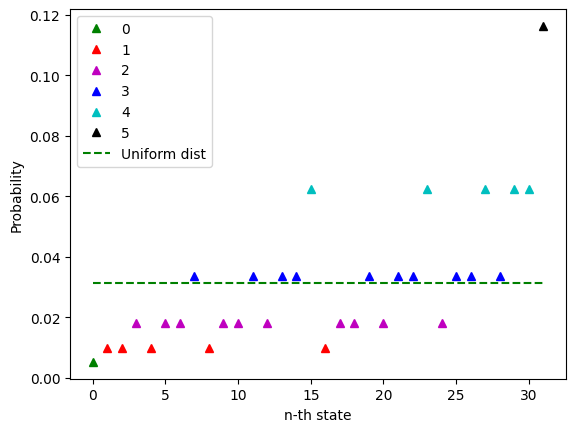

In [24]:
### Plot results ###

# Color code the number of 1's in a given state
colors = ["g", "r", "m", "b", "c", "k"]
sorted_states = [[], [], [], [], [], []]

# Sort states according to number of 1's
for i, state in enumerate(all_states):
    color_idx = len(state[state == 1])
    sorted_states[color_idx].append(i)
    
# Plot
for i, states in enumerate(sorted_states):
    plt.plot(states, v_prob_model[states], f"{colors[i]}^", label=f"{i}")

plt.plot(np.arange(32), [1/32 for i in range(32)], "g--", label="Uniform dist")
plt.xlabel("n-th state")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [6]:
### Now lets choose a bunch of different inputs for W. ###

In [7]:
# Array to store W's in
W_array = []
titles = ["Identity",
          "1's",
          "1's - identity",
          "Diagonal ones of size 3",
          "I + 1's first row",
          "I + 1's first column"]

# Identity
W_array.append(torch.tensor(np.identity(5), dtype=torch.float))

# All ones (1's)
W_array.append(torch.ones((5,5), dtype=torch.float))

# 1's - Identity
W = torch.ones((5,5), dtype=torch.float)
W -= torch.tensor(np.identity(5), dtype=torch.float)
W_array.append(W)

# Diagonal ones of size 3
W_array.append(torch.tensor(generate_matrix(5), dtype=torch.float))

# Identity + 1's on the first row
W = torch.tensor(np.identity(5), dtype=torch.float)
W[:, 0] = 1
W_array.append(W)

# Identity + 1's on the first column
W = torch.tensor(np.identity(5), dtype=torch.float)
W[0, :] = 1
W_array.append(W)

W_array

[tensor([[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]]),
 tensor([[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]),
 tensor([[0., 1., 1., 1., 1.],
         [1., 0., 1., 1., 1.],
         [1., 1., 0., 1., 1.],
         [1., 1., 1., 0., 1.],
         [1., 1., 1., 1., 0.]]),
 tensor([[1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.]]),
 tensor([[1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0.],
         [1., 0., 1., 0., 0.],
         [1., 0., 0., 1., 0.],
         [1., 0., 0., 0., 1.]]),
 tensor([[1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]])]

Partition function Z = 6114.03271484375


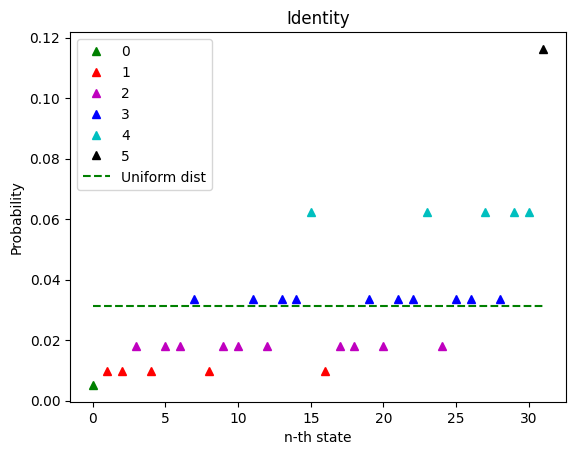

Partition function Z = 77161996288.0


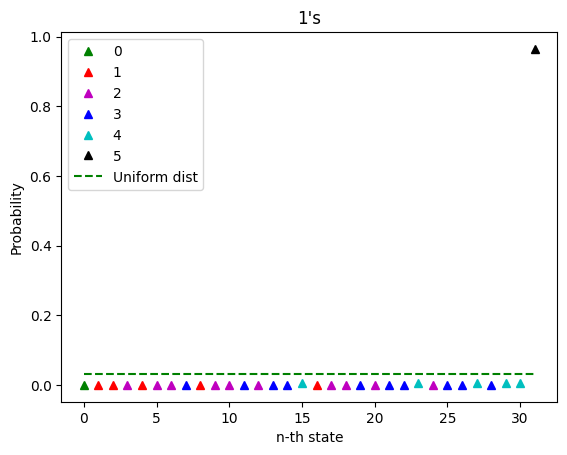

Partition function Z = 588912000.0


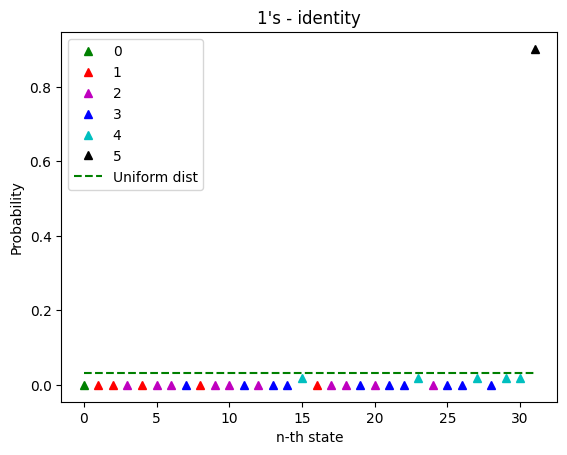

Partition function Z = 1124639.0


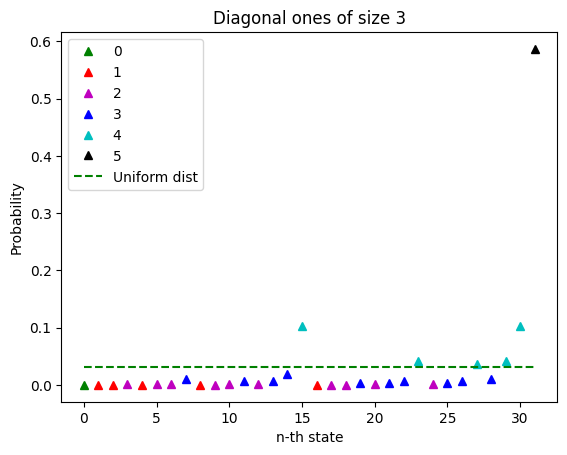

Partition function Z = 82036.609375


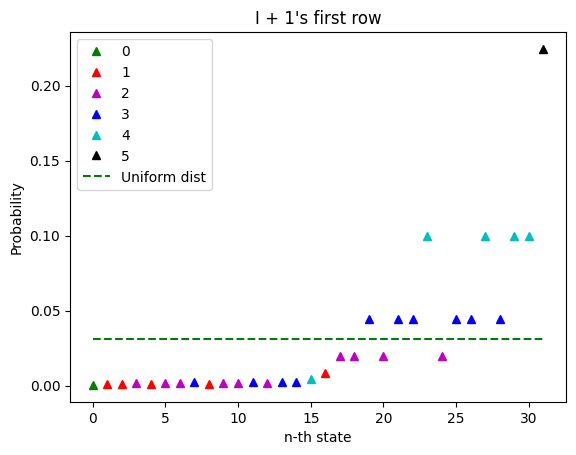

Partition function Z = 82036.609375


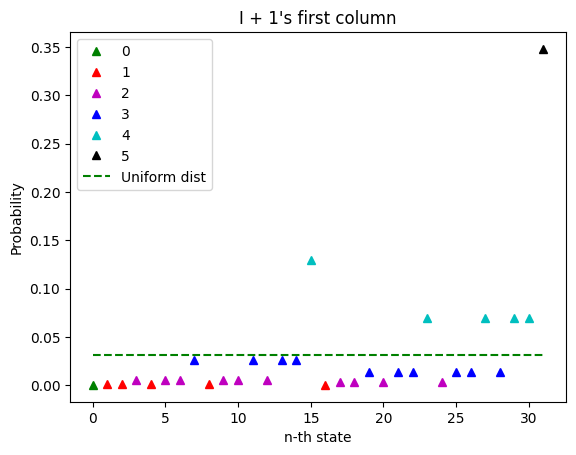

In [8]:
### Plot results ###

for i, W in enumerate(W_array):
    # Compute P(v)
    _, v_prob_model = compute_pv(W, v_bias, h_bias, all_states)
    
    # Plot
    for j, states in enumerate(sorted_states):
        plt.plot(states, v_prob_model[states], f"{colors[j]}^", label=f"{j}")

    plt.plot(np.arange(32), [1/32 for i in range(32)], "g--", label="Uniform dist")
    plt.xlabel("n-th state")
    plt.ylabel("Probability")
    plt.legend()
    plt.title(titles[i])
    plt.show()

### 1.2 Visible biases

Choose three W's. Identity, diagonal ones of size 3 and the identity + 1's on the first column. For each of these choose v_biases to be 1) all ones, 2) all zeros and 3) all -1's

In [9]:
# Choose W's
W_idxs = [0, 3, 5]
W_array_v = []
for idx in W_idxs:
    W_array_v.append(W_array[idx])

# Visible biases
h_bias = 1 * torch.zeros(5, dtype=torch.float)
v_biases_array = []

# 1's
v_bias = torch.ones(5, dtype=torch.float)
v_biases_array.append(v_bias)

# zeros
v_bias = torch.zeros(5, dtype=torch.float)
v_biases_array.append(v_bias)

# -1's
v_bias = -1 * torch.ones(5, dtype=torch.float)
v_biases_array.append(v_bias)

# Create new titles 
titles_v = ["1's", "0's", "-1's"]
v_biases_array

[tensor([1., 1., 1., 1., 1.]),
 tensor([0., 0., 0., 0., 0.]),
 tensor([-1., -1., -1., -1., -1.])]

Partition function Z = 260161.6875


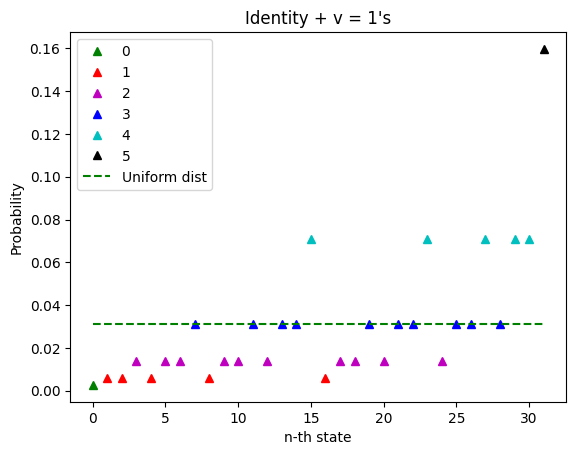

Partition function Z = 6114.03271484375


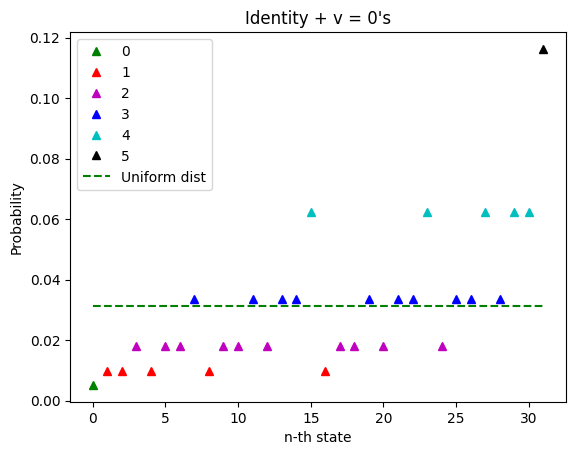

Partition function Z = 433.2940368652344


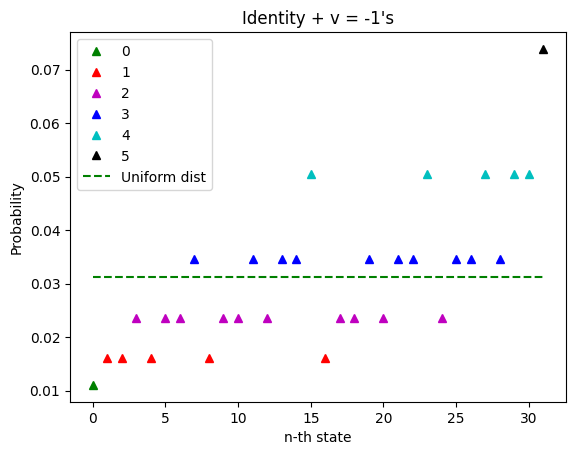

Partition function Z = 119756528.0


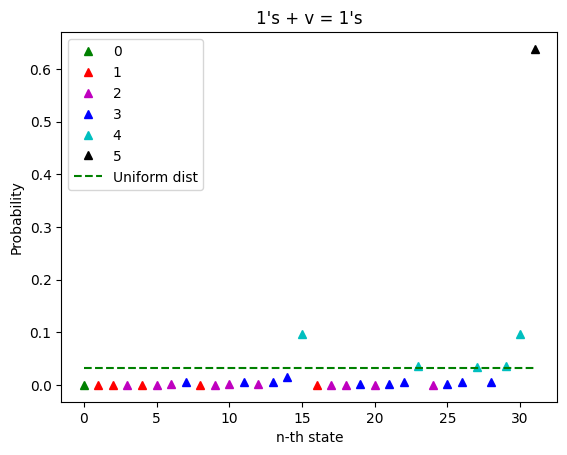

Partition function Z = 1124639.0


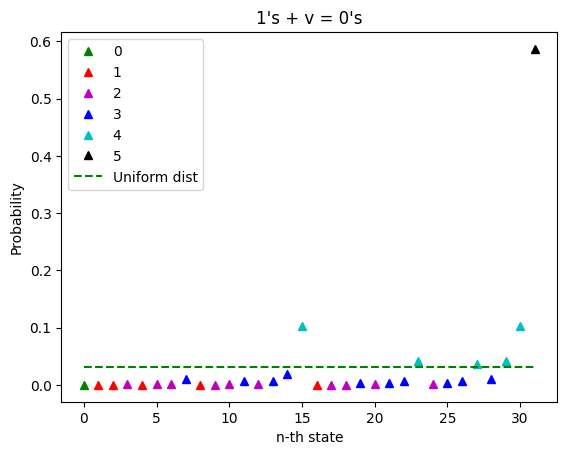

Partition function Z = 17294.857421875


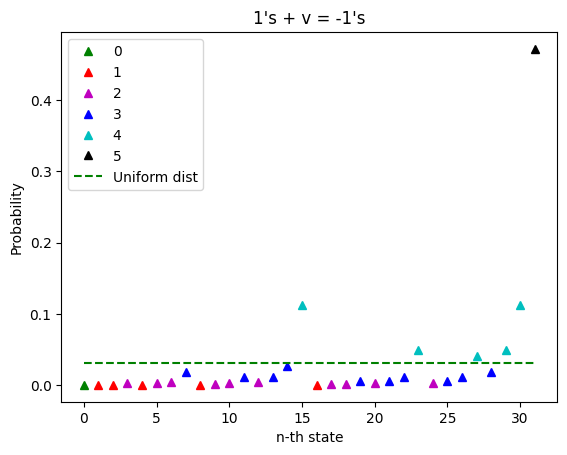

Partition function Z = 5044109.5


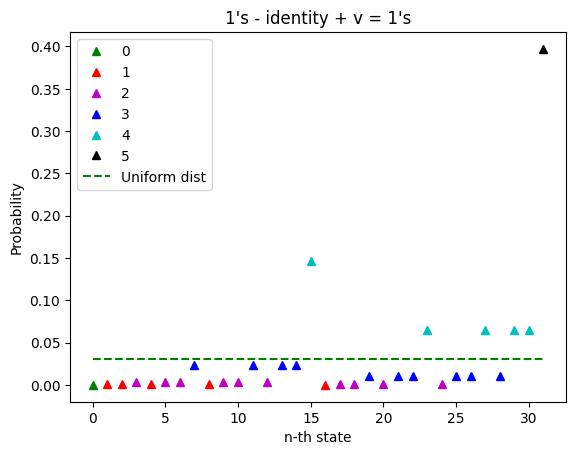

Partition function Z = 82036.609375


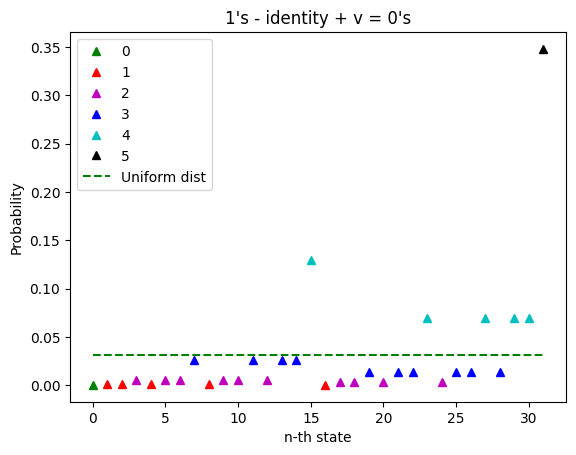

Partition function Z = 3189.67578125


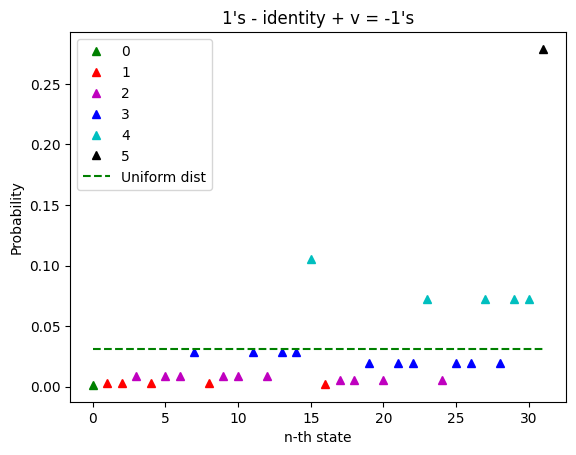

In [27]:
### Plot results ###
h_bias = torch.zeros(5, dtype=torch.float)

for i, W in enumerate(W_array_v):
    for k, v_bias in enumerate(v_biases_array):
        # Compute P(v)
        _, v_prob_model = compute_pv(W, v_bias, h_bias, all_states)

        # Plot
        for j, states in enumerate(sorted_states):
            plt.plot(states, v_prob_model[states], f"{colors[j]}^", label=f"{j}")

        plt.plot(np.arange(32), [1/32 for i in range(32)], "g--", label="Uniform dist")
        plt.xlabel("n-th state")
        plt.ylabel("Probability")
        plt.legend()
        plt.title(f"{titles[i]} + v = {titles_v[k]}")
        plt.show()

### 1.2 Hidden biases

Choose three W's. Identity, diagonal ones of size 3 and the identity + 1's on the first column. For each of these choose h_biases to be 1) all ones, 2) all zeros and 3) all -1's

In [11]:
# Choose W's
W_idxs = [0, 3, 5]
W_array_h = []
for idx in W_idxs:
    W_array_h.append(W_array[idx])

# Visible biases
v_bias = 1 * torch.zeros(5, dtype=torch.float)
h_biases_array = []

# 1's
h_bias = torch.ones(5, dtype=torch.float)
h_biases_array.append(h_bias)

# zeros
v_bias = torch.zeros(5, dtype=torch.float)
h_biases_array.append(h_bias)

# -1's
h_bias = -1 * torch.ones(5, dtype=torch.float)
h_biases_array.append(h_bias)

# Create new titles 
titles_h = ["1's", "0's", "-1's"]
h_biases_array

[tensor([1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1.]),
 tensor([-1., -1., -1., -1., -1.])]

Partition function Z = 260161.65625


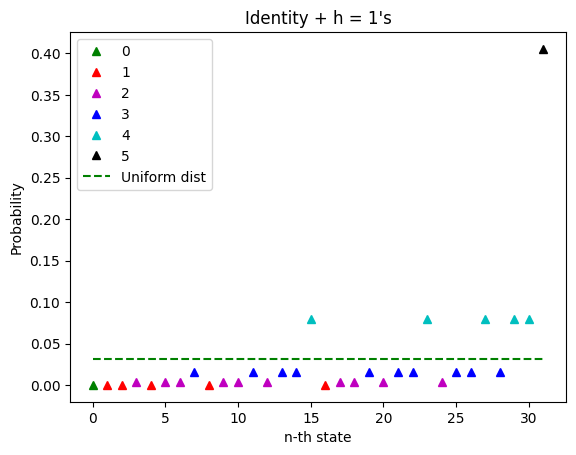

Partition function Z = 260161.65625


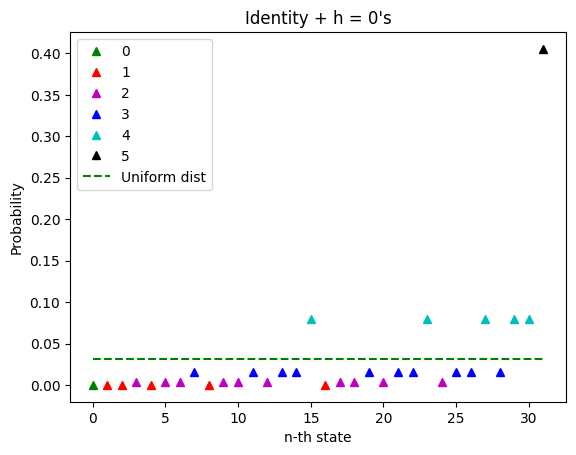

Partition function Z = 433.2940368652344


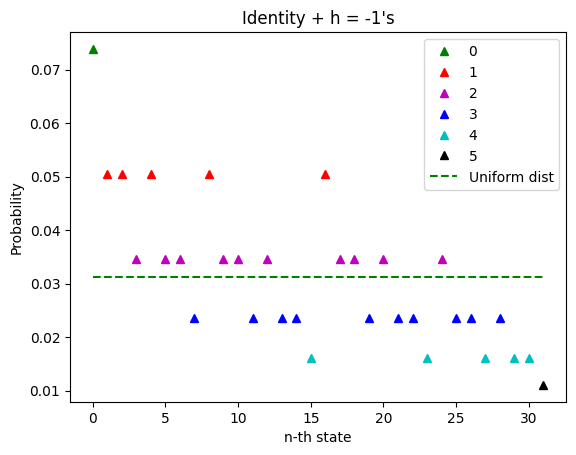

Partition function Z = 119756528.0


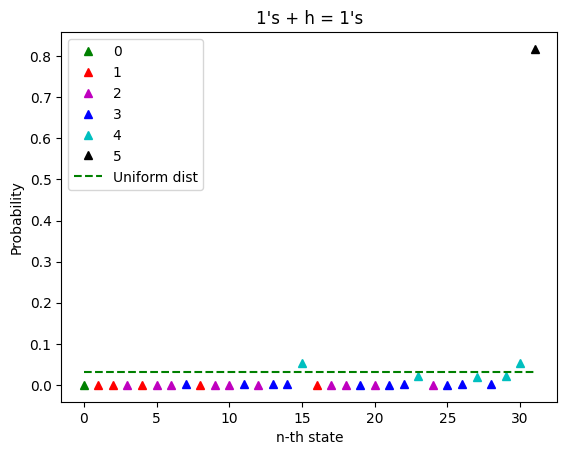

Partition function Z = 119756528.0


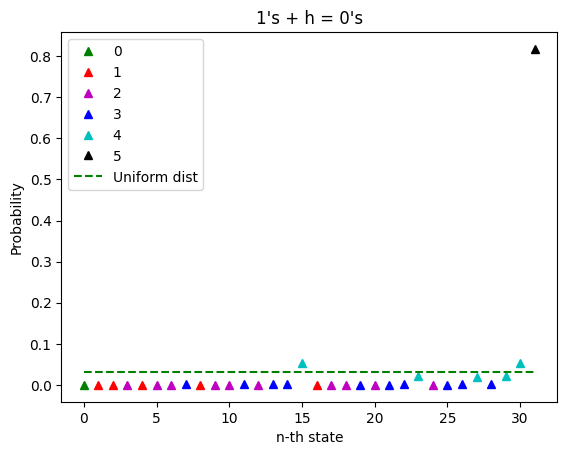

Partition function Z = 17294.85546875


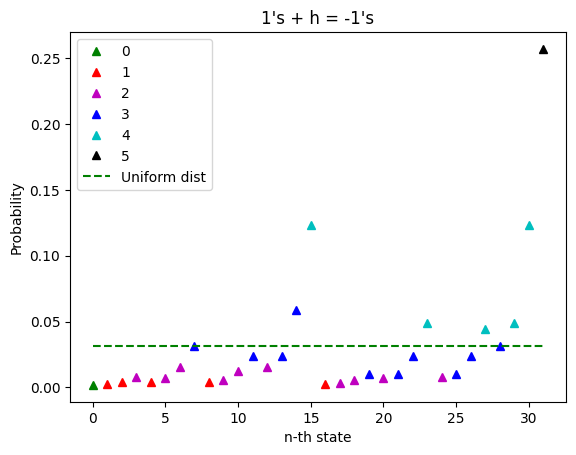

Partition function Z = 6411366.0


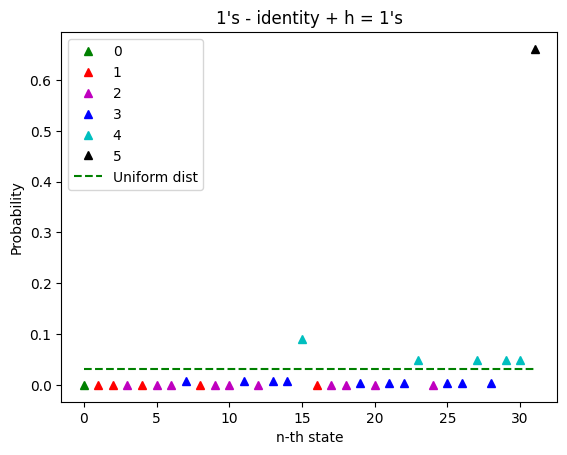

Partition function Z = 6411366.0


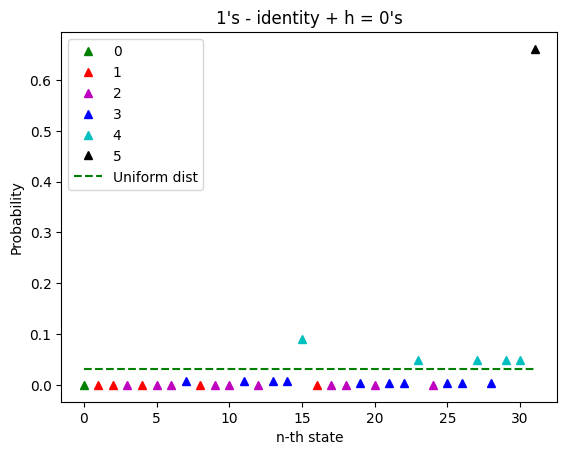

Partition function Z = 2314.400390625


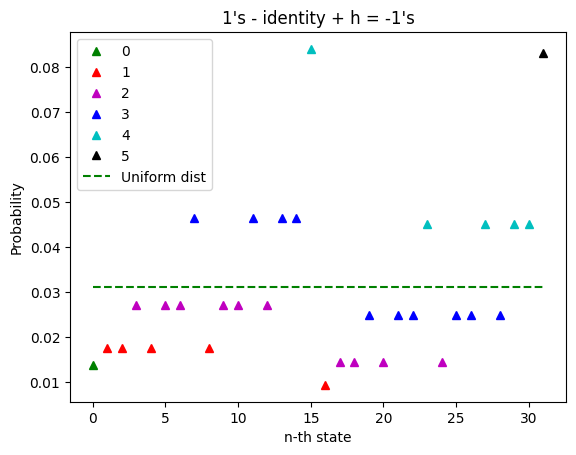

In [12]:
### Plot results ###
for i, W in enumerate(W_array_h):
    for k, h_bias in enumerate(h_biases_array):
        # Compute P(v)
        _, v_prob_model = compute_pv(W, v_bias, h_bias, all_states)

        # Plot
        for j, states in enumerate(sorted_states):
            plt.plot(states, v_prob_model[states], f"{colors[j]}^", label=f"{j}")

        plt.plot(np.arange(32), [1/32 for i in range(32)], "g--", label="Uniform dist")
        plt.xlabel("n-th state")
        plt.ylabel("Probability")
        plt.legend()
        plt.title(f"{titles[i]} + h = {titles_h[k]}")
        plt.show()

# 2. Second test
Now we choose some P(v)'s we found above, sample from it and see if the RBM can correctly learn P(v).

In [13]:
# Choose weights
v_bias = 1 * torch.zeros(5, dtype=torch.float)
h_bias = 1 * torch.zeros(5, dtype=torch.float)
W = torch.tensor(np.identity(5), dtype=torch.float)

# Generate a list containing all possible states
all_states = create_all_states(5)

# Compute P(v)
_, pv_exact = compute_pv(W, v_bias, h_bias, all_states)
pv_exact.numpy()

Partition function Z = 6114.03271484375


array([0.00523386, 0.00973049, 0.00973049, 0.01809034, 0.00973049,
       0.01809034, 0.01809034, 0.0336325 , 0.00973049, 0.01809034,
       0.01809034, 0.0336325 , 0.01809035, 0.0336325 , 0.0336325 ,
       0.06252755, 0.00973049, 0.01809034, 0.01809034, 0.0336325 ,
       0.01809034, 0.0336325 , 0.0336325 , 0.06252755, 0.01809034,
       0.0336325 , 0.0336325 , 0.06252756, 0.03363251, 0.06252756,
       0.06252756, 0.11624753], dtype=float32)

In [14]:
# Sample from P(v)
N = 5000
dataset = np.random.choice(np.arange(len(pv_exact)), size=(N), p=pv_exact.numpy())

# Convert int values to binary arrays
n = 5
dataset = convert_to_binary(dataset, n)
dataset.shape

torch.Size([5000, 5])

In [15]:
from torch.optim import Optimizer
class RBMOptimizer(Optimizer):
    def __init__(self, rbm, learning_rate=0.01, weight_decay=0, momentum=0):
        defaults = dict(learning_rate=learning_rate, weight_decay=weight_decay, momentum=momentum)
        super().__init__(rbm.parameters(), defaults)
        self.rbm = rbm

    def step(self, v_bias_update, h_bias_update, vh_weight_update):
        for group in self.param_groups:
            # Learning params
            learning_rate = group["learning_rate"]
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]

            # Update weights
            self.rbm.v_bias += learning_rate * v_bias_update
            self.rbm.h_bias += learning_rate * h_bias_update
            self.rbm.W += learning_rate * vh_weight_update #- weight_decay * torch.sign(self.rbm.W)

In [22]:
### Train the RBM ###

# Model parameters
n_visible = 5
n_hidden = 5

# Learning parameters
batch_size = len(dataset)
epochs = 5000
learning_rate = 0.8
CD_depth = 1

# Create RBM model
rbm = RBM(n_visible, n_hidden)

# Convert dataset to probabilities
convert_binary_variables_to_probabilities

# Optimizer
optimizer = RBMOptimizer(rbm, learning_rate)

# Train model
rbm.train(dataset, epochs=epochs, verbose=True, optimizer=optimizer)

Epoch [1/5000], Reconstructions errors: [tensor(6251.3940, dtype=torch.float64), tensor(6249.5981, dtype=torch.float64), tensor(3588508.7500, dtype=torch.float64)]
Epoch [2/5000], Reconstructions errors: [tensor(5838.5640, dtype=torch.float64), tensor(6185.3882, dtype=torch.float64), tensor(1640175.3750, dtype=torch.float64)]
Epoch [3/5000], Reconstructions errors: [tensor(5704.6807, dtype=torch.float64), tensor(6078.9932, dtype=torch.float64), tensor(487225., dtype=torch.float64)]
Epoch [4/5000], Reconstructions errors: [tensor(5678.2661, dtype=torch.float64), tensor(5992.7363, dtype=torch.float64), tensor(109238.7422, dtype=torch.float64)]
Epoch [5/5000], Reconstructions errors: [tensor(5676.2979, dtype=torch.float64), tensor(5948.7163, dtype=torch.float64), tensor(25433.5586, dtype=torch.float64)]
Epoch [6/5000], Reconstructions errors: [tensor(5676.7671, dtype=torch.float64), tensor(5928.9302, dtype=torch.float64), tensor(8562.1533, dtype=torch.float64)]
Epoch [7/5000], Reconstruct

Epoch [53/5000], Reconstructions errors: [tensor(5677.9712, dtype=torch.float64), tensor(5647.1201, dtype=torch.float64), tensor(9715.7480, dtype=torch.float64)]
Epoch [54/5000], Reconstructions errors: [tensor(5679.6895, dtype=torch.float64), tensor(5641.8979, dtype=torch.float64), tensor(10423.1436, dtype=torch.float64)]
Epoch [55/5000], Reconstructions errors: [tensor(5678.7568, dtype=torch.float64), tensor(5632.7329, dtype=torch.float64), tensor(10954.8037, dtype=torch.float64)]
Epoch [56/5000], Reconstructions errors: [tensor(5678.2607, dtype=torch.float64), tensor(5604.7354, dtype=torch.float64), tensor(11046.4990, dtype=torch.float64)]
Epoch [57/5000], Reconstructions errors: [tensor(5679.0674, dtype=torch.float64), tensor(5617.0396, dtype=torch.float64), tensor(11230.2539, dtype=torch.float64)]
Epoch [58/5000], Reconstructions errors: [tensor(5680.0801, dtype=torch.float64), tensor(5608.4277, dtype=torch.float64), tensor(12649.7051, dtype=torch.float64)]
Epoch [59/5000], Recons

Epoch [113/5000], Reconstructions errors: [tensor(5708.0527, dtype=torch.float64), tensor(5760.2554, dtype=torch.float64), tensor(585587., dtype=torch.float64)]
Epoch [114/5000], Reconstructions errors: [tensor(5719.7979, dtype=torch.float64), tensor(5770.3208, dtype=torch.float64), tensor(620588.6250, dtype=torch.float64)]
Epoch [115/5000], Reconstructions errors: [tensor(5733.9634, dtype=torch.float64), tensor(5783.3877, dtype=torch.float64), tensor(658770.6250, dtype=torch.float64)]
Epoch [116/5000], Reconstructions errors: [tensor(5738.0625, dtype=torch.float64), tensor(5838.7461, dtype=torch.float64), tensor(693872.1250, dtype=torch.float64)]
Epoch [117/5000], Reconstructions errors: [tensor(5755.7920, dtype=torch.float64), tensor(5821.7983, dtype=torch.float64), tensor(732485.6250, dtype=torch.float64)]
Epoch [118/5000], Reconstructions errors: [tensor(5755.5918, dtype=torch.float64), tensor(5828.7197, dtype=torch.float64), tensor(759899.5625, dtype=torch.float64)]
Epoch [119/500

Epoch [176/5000], Reconstructions errors: [tensor(6132.4590, dtype=torch.float64), tensor(5653.7202, dtype=torch.float64), tensor(414385.9375, dtype=torch.float64)]
Epoch [177/5000], Reconstructions errors: [tensor(6092.7437, dtype=torch.float64), tensor(5714.5068, dtype=torch.float64), tensor(392894.6562, dtype=torch.float64)]
Epoch [178/5000], Reconstructions errors: [tensor(6112.9858, dtype=torch.float64), tensor(5705.8584, dtype=torch.float64), tensor(391614.7188, dtype=torch.float64)]
Epoch [179/5000], Reconstructions errors: [tensor(6059.2295, dtype=torch.float64), tensor(5631.2534, dtype=torch.float64), tensor(386594.8750, dtype=torch.float64)]
Epoch [180/5000], Reconstructions errors: [tensor(6078.1777, dtype=torch.float64), tensor(5596.2080, dtype=torch.float64), tensor(391039.8750, dtype=torch.float64)]
Epoch [181/5000], Reconstructions errors: [tensor(6083.6475, dtype=torch.float64), tensor(5638.7520, dtype=torch.float64), tensor(395611.3125, dtype=torch.float64)]
Epoch [182

Epoch [233/5000], Reconstructions errors: [tensor(5408.5508, dtype=torch.float64), tensor(4860.1733, dtype=torch.float64), tensor(123929.2812, dtype=torch.float64)]
Epoch [234/5000], Reconstructions errors: [tensor(5423.8062, dtype=torch.float64), tensor(4878.4644, dtype=torch.float64), tensor(100438.4766, dtype=torch.float64)]
Epoch [235/5000], Reconstructions errors: [tensor(5373.2876, dtype=torch.float64), tensor(4783.3101, dtype=torch.float64), tensor(99290.3359, dtype=torch.float64)]
Epoch [236/5000], Reconstructions errors: [tensor(5423.3975, dtype=torch.float64), tensor(4877.2915, dtype=torch.float64), tensor(125697.4062, dtype=torch.float64)]
Epoch [237/5000], Reconstructions errors: [tensor(5320.5513, dtype=torch.float64), tensor(4761.9482, dtype=torch.float64), tensor(114653.5000, dtype=torch.float64)]
Epoch [238/5000], Reconstructions errors: [tensor(5412.5156, dtype=torch.float64), tensor(4747.6138, dtype=torch.float64), tensor(127310.9375, dtype=torch.float64)]
Epoch [239/

Epoch [306/5000], Reconstructions errors: [tensor(4215.3389, dtype=torch.float64), tensor(3675.3157, dtype=torch.float64), tensor(71043.2969, dtype=torch.float64)]
Epoch [307/5000], Reconstructions errors: [tensor(4362.7822, dtype=torch.float64), tensor(3759.3022, dtype=torch.float64), tensor(89756.5781, dtype=torch.float64)]
Epoch [308/5000], Reconstructions errors: [tensor(4191.5059, dtype=torch.float64), tensor(3606.9695, dtype=torch.float64), tensor(60594.6172, dtype=torch.float64)]
Epoch [309/5000], Reconstructions errors: [tensor(4226.2759, dtype=torch.float64), tensor(3674.6660, dtype=torch.float64), tensor(76252.1719, dtype=torch.float64)]
Epoch [310/5000], Reconstructions errors: [tensor(4194.7007, dtype=torch.float64), tensor(3617.0244, dtype=torch.float64), tensor(88585.8906, dtype=torch.float64)]
Epoch [311/5000], Reconstructions errors: [tensor(4222.8750, dtype=torch.float64), tensor(3662.2485, dtype=torch.float64), tensor(69802.2734, dtype=torch.float64)]
Epoch [312/5000]

Epoch [359/5000], Reconstructions errors: [tensor(3717.4551, dtype=torch.float64), tensor(3118.0283, dtype=torch.float64), tensor(40780.1172, dtype=torch.float64)]
Epoch [360/5000], Reconstructions errors: [tensor(3697.3044, dtype=torch.float64), tensor(3141.7380, dtype=torch.float64), tensor(39964.9609, dtype=torch.float64)]
Epoch [361/5000], Reconstructions errors: [tensor(3587.4033, dtype=torch.float64), tensor(3035.5269, dtype=torch.float64), tensor(67946.3672, dtype=torch.float64)]
Epoch [362/5000], Reconstructions errors: [tensor(3642.4131, dtype=torch.float64), tensor(3093.2358, dtype=torch.float64), tensor(59052.7812, dtype=torch.float64)]
Epoch [363/5000], Reconstructions errors: [tensor(3677.0662, dtype=torch.float64), tensor(3115.8181, dtype=torch.float64), tensor(55530.5664, dtype=torch.float64)]
Epoch [364/5000], Reconstructions errors: [tensor(3627.3894, dtype=torch.float64), tensor(3096.5928, dtype=torch.float64), tensor(44301.2383, dtype=torch.float64)]
Epoch [365/5000]

Epoch [424/5000], Reconstructions errors: [tensor(2825.6135, dtype=torch.float64), tensor(2333.4597, dtype=torch.float64), tensor(29987.1973, dtype=torch.float64)]
Epoch [425/5000], Reconstructions errors: [tensor(2787.9707, dtype=torch.float64), tensor(2340.6250, dtype=torch.float64), tensor(49583.1719, dtype=torch.float64)]
Epoch [426/5000], Reconstructions errors: [tensor(2787.9551, dtype=torch.float64), tensor(2303.7942, dtype=torch.float64), tensor(38450.5625, dtype=torch.float64)]
Epoch [427/5000], Reconstructions errors: [tensor(2821.0322, dtype=torch.float64), tensor(2287.7314, dtype=torch.float64), tensor(34417.3633, dtype=torch.float64)]
Epoch [428/5000], Reconstructions errors: [tensor(2791.0623, dtype=torch.float64), tensor(2344.5823, dtype=torch.float64), tensor(44847.9609, dtype=torch.float64)]
Epoch [429/5000], Reconstructions errors: [tensor(2822.5503, dtype=torch.float64), tensor(2332.9875, dtype=torch.float64), tensor(28131.1289, dtype=torch.float64)]
Epoch [430/5000]

Epoch [475/5000], Reconstructions errors: [tensor(2240.7783, dtype=torch.float64), tensor(1823.7979, dtype=torch.float64), tensor(20821.2109, dtype=torch.float64)]
Epoch [476/5000], Reconstructions errors: [tensor(2232.6653, dtype=torch.float64), tensor(1783.8452, dtype=torch.float64), tensor(21756.0273, dtype=torch.float64)]
Epoch [477/5000], Reconstructions errors: [tensor(2225.0444, dtype=torch.float64), tensor(1820.5619, dtype=torch.float64), tensor(40320.5391, dtype=torch.float64)]
Epoch [478/5000], Reconstructions errors: [tensor(2300.4055, dtype=torch.float64), tensor(1881.4365, dtype=torch.float64), tensor(23497.8184, dtype=torch.float64)]
Epoch [479/5000], Reconstructions errors: [tensor(2288.5088, dtype=torch.float64), tensor(1834.2997, dtype=torch.float64), tensor(30876.2715, dtype=torch.float64)]
Epoch [480/5000], Reconstructions errors: [tensor(2151.3840, dtype=torch.float64), tensor(1754.0284, dtype=torch.float64), tensor(24042.4746, dtype=torch.float64)]
Epoch [481/5000]

Epoch [541/5000], Reconstructions errors: [tensor(1769.3167, dtype=torch.float64), tensor(1408.2594, dtype=torch.float64), tensor(30641.6953, dtype=torch.float64)]
Epoch [542/5000], Reconstructions errors: [tensor(1853.4441, dtype=torch.float64), tensor(1492.6538, dtype=torch.float64), tensor(11432.9795, dtype=torch.float64)]
Epoch [543/5000], Reconstructions errors: [tensor(1780.8702, dtype=torch.float64), tensor(1418.2242, dtype=torch.float64), tensor(21775.0703, dtype=torch.float64)]
Epoch [544/5000], Reconstructions errors: [tensor(1747.1134, dtype=torch.float64), tensor(1400.2871, dtype=torch.float64), tensor(24437.9258, dtype=torch.float64)]
Epoch [545/5000], Reconstructions errors: [tensor(1751.9238, dtype=torch.float64), tensor(1428.0291, dtype=torch.float64), tensor(11966.6152, dtype=torch.float64)]
Epoch [546/5000], Reconstructions errors: [tensor(1803.1423, dtype=torch.float64), tensor(1456.6481, dtype=torch.float64), tensor(13293.7783, dtype=torch.float64)]
Epoch [547/5000]

Epoch [605/5000], Reconstructions errors: [tensor(1474.2422, dtype=torch.float64), tensor(1160.0891, dtype=torch.float64), tensor(28534.3867, dtype=torch.float64)]
Epoch [606/5000], Reconstructions errors: [tensor(1480.8262, dtype=torch.float64), tensor(1193.6343, dtype=torch.float64), tensor(25152.8887, dtype=torch.float64)]
Epoch [607/5000], Reconstructions errors: [tensor(1424.8732, dtype=torch.float64), tensor(1129.6052, dtype=torch.float64), tensor(31656.9590, dtype=torch.float64)]
Epoch [608/5000], Reconstructions errors: [tensor(1512.7056, dtype=torch.float64), tensor(1178.0436, dtype=torch.float64), tensor(8693.8799, dtype=torch.float64)]
Epoch [609/5000], Reconstructions errors: [tensor(1402.5781, dtype=torch.float64), tensor(1136.8523, dtype=torch.float64), tensor(17870.9941, dtype=torch.float64)]
Epoch [610/5000], Reconstructions errors: [tensor(1421.0892, dtype=torch.float64), tensor(1135.9106, dtype=torch.float64), tensor(12687.1631, dtype=torch.float64)]
Epoch [611/5000],

Epoch [673/5000], Reconstructions errors: [tensor(1195.2415, dtype=torch.float64), tensor(919.5602, dtype=torch.float64), tensor(7133.1729, dtype=torch.float64)]
Epoch [674/5000], Reconstructions errors: [tensor(1258.8677, dtype=torch.float64), tensor(987.5462, dtype=torch.float64), tensor(9144.9453, dtype=torch.float64)]
Epoch [675/5000], Reconstructions errors: [tensor(1303.2108, dtype=torch.float64), tensor(1013.3489, dtype=torch.float64), tensor(7033.8931, dtype=torch.float64)]
Epoch [676/5000], Reconstructions errors: [tensor(1236.8125, dtype=torch.float64), tensor(948.8349, dtype=torch.float64), tensor(13938.6387, dtype=torch.float64)]
Epoch [677/5000], Reconstructions errors: [tensor(1234.4644, dtype=torch.float64), tensor(954.7018, dtype=torch.float64), tensor(7928.0908, dtype=torch.float64)]
Epoch [678/5000], Reconstructions errors: [tensor(1248.3940, dtype=torch.float64), tensor(970.4688, dtype=torch.float64), tensor(8005.6689, dtype=torch.float64)]
Epoch [679/5000], Reconstr

Epoch [744/5000], Reconstructions errors: [tensor(1074.7681, dtype=torch.float64), tensor(842.2134, dtype=torch.float64), tensor(8632.9189, dtype=torch.float64)]
Epoch [745/5000], Reconstructions errors: [tensor(1103.0038, dtype=torch.float64), tensor(866.7960, dtype=torch.float64), tensor(30102.5039, dtype=torch.float64)]
Epoch [746/5000], Reconstructions errors: [tensor(1078.7800, dtype=torch.float64), tensor(850.6864, dtype=torch.float64), tensor(18952.2734, dtype=torch.float64)]
Epoch [747/5000], Reconstructions errors: [tensor(1059.9833, dtype=torch.float64), tensor(799.5646, dtype=torch.float64), tensor(11340.4570, dtype=torch.float64)]
Epoch [748/5000], Reconstructions errors: [tensor(1033.3781, dtype=torch.float64), tensor(793.3494, dtype=torch.float64), tensor(11018.9814, dtype=torch.float64)]
Epoch [749/5000], Reconstructions errors: [tensor(1018.9980, dtype=torch.float64), tensor(786.9266, dtype=torch.float64), tensor(15353.7178, dtype=torch.float64)]
Epoch [750/5000], Recon

Epoch [798/5000], Reconstructions errors: [tensor(981.2525, dtype=torch.float64), tensor(762.3764, dtype=torch.float64), tensor(4167.6992, dtype=torch.float64)]
Epoch [799/5000], Reconstructions errors: [tensor(981.6857, dtype=torch.float64), tensor(788.8306, dtype=torch.float64), tensor(4683.5498, dtype=torch.float64)]
Epoch [800/5000], Reconstructions errors: [tensor(956.1698, dtype=torch.float64), tensor(720.3674, dtype=torch.float64), tensor(6472.0161, dtype=torch.float64)]
Epoch [801/5000], Reconstructions errors: [tensor(975.5817, dtype=torch.float64), tensor(759.1486, dtype=torch.float64), tensor(4988.2505, dtype=torch.float64)]
Epoch [802/5000], Reconstructions errors: [tensor(1013.1062, dtype=torch.float64), tensor(787.3059, dtype=torch.float64), tensor(5084.1714, dtype=torch.float64)]
Epoch [803/5000], Reconstructions errors: [tensor(998.9707, dtype=torch.float64), tensor(790.9834, dtype=torch.float64), tensor(11274.9697, dtype=torch.float64)]
Epoch [804/5000], Reconstruction

Epoch [853/5000], Reconstructions errors: [tensor(875.8147, dtype=torch.float64), tensor(657.9333, dtype=torch.float64), tensor(8458.2520, dtype=torch.float64)]
Epoch [854/5000], Reconstructions errors: [tensor(892.0275, dtype=torch.float64), tensor(690.1829, dtype=torch.float64), tensor(3947.0356, dtype=torch.float64)]
Epoch [855/5000], Reconstructions errors: [tensor(893.9509, dtype=torch.float64), tensor(695.7039, dtype=torch.float64), tensor(2712.7849, dtype=torch.float64)]
Epoch [856/5000], Reconstructions errors: [tensor(861.7330, dtype=torch.float64), tensor(666.1938, dtype=torch.float64), tensor(10275.2295, dtype=torch.float64)]
Epoch [857/5000], Reconstructions errors: [tensor(884.3729, dtype=torch.float64), tensor(695.5048, dtype=torch.float64), tensor(3369.4219, dtype=torch.float64)]
Epoch [858/5000], Reconstructions errors: [tensor(911.1011, dtype=torch.float64), tensor(683.9604, dtype=torch.float64), tensor(17597.0938, dtype=torch.float64)]
Epoch [859/5000], Reconstruction

Epoch [906/5000], Reconstructions errors: [tensor(782.8842, dtype=torch.float64), tensor(601.1256, dtype=torch.float64), tensor(4270.1035, dtype=torch.float64)]
Epoch [907/5000], Reconstructions errors: [tensor(806.0833, dtype=torch.float64), tensor(632.2404, dtype=torch.float64), tensor(13910.8477, dtype=torch.float64)]
Epoch [908/5000], Reconstructions errors: [tensor(775.3937, dtype=torch.float64), tensor(603.1188, dtype=torch.float64), tensor(7616.0586, dtype=torch.float64)]
Epoch [909/5000], Reconstructions errors: [tensor(814.4122, dtype=torch.float64), tensor(635.6849, dtype=torch.float64), tensor(4933.2041, dtype=torch.float64)]
Epoch [910/5000], Reconstructions errors: [tensor(777.5286, dtype=torch.float64), tensor(589.2466, dtype=torch.float64), tensor(2881.1462, dtype=torch.float64)]
Epoch [911/5000], Reconstructions errors: [tensor(771.7669, dtype=torch.float64), tensor(601.6284, dtype=torch.float64), tensor(5644.4312, dtype=torch.float64)]
Epoch [912/5000], Reconstructions

Epoch [958/5000], Reconstructions errors: [tensor(814.3007, dtype=torch.float64), tensor(604.2687, dtype=torch.float64), tensor(2543.5305, dtype=torch.float64)]
Epoch [959/5000], Reconstructions errors: [tensor(689.5143, dtype=torch.float64), tensor(554.8315, dtype=torch.float64), tensor(3624.0227, dtype=torch.float64)]
Epoch [960/5000], Reconstructions errors: [tensor(752.5889, dtype=torch.float64), tensor(592.0565, dtype=torch.float64), tensor(5012.9824, dtype=torch.float64)]
Epoch [961/5000], Reconstructions errors: [tensor(796.2069, dtype=torch.float64), tensor(603.1446, dtype=torch.float64), tensor(6113.2637, dtype=torch.float64)]
Epoch [962/5000], Reconstructions errors: [tensor(764.1978, dtype=torch.float64), tensor(588.2059, dtype=torch.float64), tensor(7036.0273, dtype=torch.float64)]
Epoch [963/5000], Reconstructions errors: [tensor(740.2984, dtype=torch.float64), tensor(566.7117, dtype=torch.float64), tensor(5552.2505, dtype=torch.float64)]
Epoch [964/5000], Reconstructions 

Epoch [1012/5000], Reconstructions errors: [tensor(711.3881, dtype=torch.float64), tensor(536.4939, dtype=torch.float64), tensor(4134.9009, dtype=torch.float64)]
Epoch [1013/5000], Reconstructions errors: [tensor(707.4614, dtype=torch.float64), tensor(538.2847, dtype=torch.float64), tensor(6254.3599, dtype=torch.float64)]
Epoch [1014/5000], Reconstructions errors: [tensor(702.4939, dtype=torch.float64), tensor(522.1334, dtype=torch.float64), tensor(5964.5361, dtype=torch.float64)]
Epoch [1015/5000], Reconstructions errors: [tensor(681.3708, dtype=torch.float64), tensor(533.2168, dtype=torch.float64), tensor(6875.4258, dtype=torch.float64)]
Epoch [1016/5000], Reconstructions errors: [tensor(662.6270, dtype=torch.float64), tensor(510.5843, dtype=torch.float64), tensor(1834.2067, dtype=torch.float64)]
Epoch [1017/5000], Reconstructions errors: [tensor(689.7183, dtype=torch.float64), tensor(514.4610, dtype=torch.float64), tensor(3342.4985, dtype=torch.float64)]
Epoch [1018/5000], Reconstru

Epoch [1069/5000], Reconstructions errors: [tensor(654.0328, dtype=torch.float64), tensor(498.9117, dtype=torch.float64), tensor(4290.0386, dtype=torch.float64)]
Epoch [1070/5000], Reconstructions errors: [tensor(645.7264, dtype=torch.float64), tensor(509.6264, dtype=torch.float64), tensor(4156.5415, dtype=torch.float64)]
Epoch [1071/5000], Reconstructions errors: [tensor(671.8906, dtype=torch.float64), tensor(496.8988, dtype=torch.float64), tensor(3052.7986, dtype=torch.float64)]
Epoch [1072/5000], Reconstructions errors: [tensor(622.8150, dtype=torch.float64), tensor(483.9084, dtype=torch.float64), tensor(4311.1396, dtype=torch.float64)]
Epoch [1073/5000], Reconstructions errors: [tensor(664.8549, dtype=torch.float64), tensor(522.6932, dtype=torch.float64), tensor(4874.1738, dtype=torch.float64)]
Epoch [1074/5000], Reconstructions errors: [tensor(689.6955, dtype=torch.float64), tensor(530.5656, dtype=torch.float64), tensor(4234.1826, dtype=torch.float64)]
Epoch [1075/5000], Reconstru

Epoch [1123/5000], Reconstructions errors: [tensor(637.8624, dtype=torch.float64), tensor(493.8123, dtype=torch.float64), tensor(8906.9062, dtype=torch.float64)]
Epoch [1124/5000], Reconstructions errors: [tensor(655.8306, dtype=torch.float64), tensor(500.9647, dtype=torch.float64), tensor(5242.4517, dtype=torch.float64)]
Epoch [1125/5000], Reconstructions errors: [tensor(640.2789, dtype=torch.float64), tensor(499.9589, dtype=torch.float64), tensor(2801.8975, dtype=torch.float64)]
Epoch [1126/5000], Reconstructions errors: [tensor(607.4622, dtype=torch.float64), tensor(460.2814, dtype=torch.float64), tensor(2660.3059, dtype=torch.float64)]
Epoch [1127/5000], Reconstructions errors: [tensor(623.7401, dtype=torch.float64), tensor(490.9524, dtype=torch.float64), tensor(9144.8525, dtype=torch.float64)]
Epoch [1128/5000], Reconstructions errors: [tensor(644.0131, dtype=torch.float64), tensor(495.9578, dtype=torch.float64), tensor(7232.6973, dtype=torch.float64)]
Epoch [1129/5000], Reconstru

Epoch [1178/5000], Reconstructions errors: [tensor(616.8860, dtype=torch.float64), tensor(465.5640, dtype=torch.float64), tensor(3571.1836, dtype=torch.float64)]
Epoch [1179/5000], Reconstructions errors: [tensor(555.0821, dtype=torch.float64), tensor(450.6588, dtype=torch.float64), tensor(1862.0015, dtype=torch.float64)]
Epoch [1180/5000], Reconstructions errors: [tensor(547.1321, dtype=torch.float64), tensor(419.1516, dtype=torch.float64), tensor(3669.6821, dtype=torch.float64)]
Epoch [1181/5000], Reconstructions errors: [tensor(583.4272, dtype=torch.float64), tensor(441.9583, dtype=torch.float64), tensor(1447.9353, dtype=torch.float64)]
Epoch [1182/5000], Reconstructions errors: [tensor(581.4937, dtype=torch.float64), tensor(448.7447, dtype=torch.float64), tensor(3423.4961, dtype=torch.float64)]
Epoch [1183/5000], Reconstructions errors: [tensor(582.2678, dtype=torch.float64), tensor(435.0003, dtype=torch.float64), tensor(2403.5425, dtype=torch.float64)]
Epoch [1184/5000], Reconstru

Epoch [1232/5000], Reconstructions errors: [tensor(531.5411, dtype=torch.float64), tensor(412.2696, dtype=torch.float64), tensor(5197.1807, dtype=torch.float64)]
Epoch [1233/5000], Reconstructions errors: [tensor(554.2943, dtype=torch.float64), tensor(408.3091, dtype=torch.float64), tensor(2922.9629, dtype=torch.float64)]
Epoch [1234/5000], Reconstructions errors: [tensor(529.6448, dtype=torch.float64), tensor(401.3228, dtype=torch.float64), tensor(4081.0793, dtype=torch.float64)]
Epoch [1235/5000], Reconstructions errors: [tensor(529.6201, dtype=torch.float64), tensor(405.5621, dtype=torch.float64), tensor(4704.5771, dtype=torch.float64)]
Epoch [1236/5000], Reconstructions errors: [tensor(544.5359, dtype=torch.float64), tensor(426.9292, dtype=torch.float64), tensor(3425.5601, dtype=torch.float64)]
Epoch [1237/5000], Reconstructions errors: [tensor(586.7296, dtype=torch.float64), tensor(475.6759, dtype=torch.float64), tensor(4077.0806, dtype=torch.float64)]
Epoch [1238/5000], Reconstru

Epoch [1286/5000], Reconstructions errors: [tensor(582.0596, dtype=torch.float64), tensor(437.9822, dtype=torch.float64), tensor(2195.5847, dtype=torch.float64)]
Epoch [1287/5000], Reconstructions errors: [tensor(504.3149, dtype=torch.float64), tensor(390.5273, dtype=torch.float64), tensor(3529.8628, dtype=torch.float64)]
Epoch [1288/5000], Reconstructions errors: [tensor(573.3903, dtype=torch.float64), tensor(440.0932, dtype=torch.float64), tensor(5198.6406, dtype=torch.float64)]
Epoch [1289/5000], Reconstructions errors: [tensor(567.2698, dtype=torch.float64), tensor(431.9157, dtype=torch.float64), tensor(4927.5059, dtype=torch.float64)]
Epoch [1290/5000], Reconstructions errors: [tensor(540.7653, dtype=torch.float64), tensor(422.3114, dtype=torch.float64), tensor(2734.5898, dtype=torch.float64)]
Epoch [1291/5000], Reconstructions errors: [tensor(520.8058, dtype=torch.float64), tensor(408.1625, dtype=torch.float64), tensor(5229.0020, dtype=torch.float64)]
Epoch [1292/5000], Reconstru

Epoch [1340/5000], Reconstructions errors: [tensor(462.7961, dtype=torch.float64), tensor(360.8896, dtype=torch.float64), tensor(4106.2568, dtype=torch.float64)]
Epoch [1341/5000], Reconstructions errors: [tensor(532.3948, dtype=torch.float64), tensor(394.6551, dtype=torch.float64), tensor(3205.7271, dtype=torch.float64)]
Epoch [1342/5000], Reconstructions errors: [tensor(520.5096, dtype=torch.float64), tensor(408.3929, dtype=torch.float64), tensor(4399.2314, dtype=torch.float64)]
Epoch [1343/5000], Reconstructions errors: [tensor(500.5307, dtype=torch.float64), tensor(367.9040, dtype=torch.float64), tensor(4576.6211, dtype=torch.float64)]
Epoch [1344/5000], Reconstructions errors: [tensor(527.1675, dtype=torch.float64), tensor(394.4429, dtype=torch.float64), tensor(4083.0469, dtype=torch.float64)]
Epoch [1345/5000], Reconstructions errors: [tensor(508.3527, dtype=torch.float64), tensor(399.4838, dtype=torch.float64), tensor(5967.5786, dtype=torch.float64)]
Epoch [1346/5000], Reconstru

Epoch [1395/5000], Reconstructions errors: [tensor(504.7729, dtype=torch.float64), tensor(386.7780, dtype=torch.float64), tensor(2311.8894, dtype=torch.float64)]
Epoch [1396/5000], Reconstructions errors: [tensor(517.5000, dtype=torch.float64), tensor(386.6508, dtype=torch.float64), tensor(1464.6648, dtype=torch.float64)]
Epoch [1397/5000], Reconstructions errors: [tensor(487.7775, dtype=torch.float64), tensor(369.9758, dtype=torch.float64), tensor(2122.7832, dtype=torch.float64)]
Epoch [1398/5000], Reconstructions errors: [tensor(515.5936, dtype=torch.float64), tensor(418.3662, dtype=torch.float64), tensor(3838.7109, dtype=torch.float64)]
Epoch [1399/5000], Reconstructions errors: [tensor(493.5611, dtype=torch.float64), tensor(387.7426, dtype=torch.float64), tensor(4935.6724, dtype=torch.float64)]
Epoch [1400/5000], Reconstructions errors: [tensor(471.1796, dtype=torch.float64), tensor(363.9520, dtype=torch.float64), tensor(1907.4705, dtype=torch.float64)]
Epoch [1401/5000], Reconstru

Epoch [1447/5000], Reconstructions errors: [tensor(470.0626, dtype=torch.float64), tensor(350.0591, dtype=torch.float64), tensor(9104.8301, dtype=torch.float64)]
Epoch [1448/5000], Reconstructions errors: [tensor(473.2428, dtype=torch.float64), tensor(371.1179, dtype=torch.float64), tensor(1493.0347, dtype=torch.float64)]
Epoch [1449/5000], Reconstructions errors: [tensor(461.6428, dtype=torch.float64), tensor(357.3157, dtype=torch.float64), tensor(3785.9688, dtype=torch.float64)]
Epoch [1450/5000], Reconstructions errors: [tensor(497.2040, dtype=torch.float64), tensor(384.0016, dtype=torch.float64), tensor(8777.3887, dtype=torch.float64)]
Epoch [1451/5000], Reconstructions errors: [tensor(458.3376, dtype=torch.float64), tensor(349.0255, dtype=torch.float64), tensor(5476.1489, dtype=torch.float64)]
Epoch [1452/5000], Reconstructions errors: [tensor(432.7551, dtype=torch.float64), tensor(326.5041, dtype=torch.float64), tensor(2304.7336, dtype=torch.float64)]
Epoch [1453/5000], Reconstru

Epoch [1502/5000], Reconstructions errors: [tensor(459.7709, dtype=torch.float64), tensor(357.1841, dtype=torch.float64), tensor(2024.9866, dtype=torch.float64)]
Epoch [1503/5000], Reconstructions errors: [tensor(456.5887, dtype=torch.float64), tensor(357.1500, dtype=torch.float64), tensor(2441.5435, dtype=torch.float64)]
Epoch [1504/5000], Reconstructions errors: [tensor(468.5873, dtype=torch.float64), tensor(358.2557, dtype=torch.float64), tensor(3482.0366, dtype=torch.float64)]
Epoch [1505/5000], Reconstructions errors: [tensor(427.8999, dtype=torch.float64), tensor(323.7147, dtype=torch.float64), tensor(1453.0383, dtype=torch.float64)]
Epoch [1506/5000], Reconstructions errors: [tensor(431.0458, dtype=torch.float64), tensor(336.4758, dtype=torch.float64), tensor(900.9846, dtype=torch.float64)]
Epoch [1507/5000], Reconstructions errors: [tensor(452.6583, dtype=torch.float64), tensor(353.2685, dtype=torch.float64), tensor(2344.3774, dtype=torch.float64)]
Epoch [1508/5000], Reconstruc

Epoch [1555/5000], Reconstructions errors: [tensor(453.7827, dtype=torch.float64), tensor(342.4392, dtype=torch.float64), tensor(3870.3457, dtype=torch.float64)]
Epoch [1556/5000], Reconstructions errors: [tensor(412.3713, dtype=torch.float64), tensor(314.7499, dtype=torch.float64), tensor(2650.0664, dtype=torch.float64)]
Epoch [1557/5000], Reconstructions errors: [tensor(448.0054, dtype=torch.float64), tensor(330.5162, dtype=torch.float64), tensor(1659.4263, dtype=torch.float64)]
Epoch [1558/5000], Reconstructions errors: [tensor(476.5401, dtype=torch.float64), tensor(359.3785, dtype=torch.float64), tensor(1856.3309, dtype=torch.float64)]
Epoch [1559/5000], Reconstructions errors: [tensor(428.0717, dtype=torch.float64), tensor(319.5098, dtype=torch.float64), tensor(2328.2454, dtype=torch.float64)]
Epoch [1560/5000], Reconstructions errors: [tensor(411.3003, dtype=torch.float64), tensor(307.7702, dtype=torch.float64), tensor(2293.5588, dtype=torch.float64)]
Epoch [1561/5000], Reconstru

Epoch [1610/5000], Reconstructions errors: [tensor(440.1963, dtype=torch.float64), tensor(350.5142, dtype=torch.float64), tensor(4806.5166, dtype=torch.float64)]
Epoch [1611/5000], Reconstructions errors: [tensor(443.0911, dtype=torch.float64), tensor(343.4935, dtype=torch.float64), tensor(2090.2563, dtype=torch.float64)]
Epoch [1612/5000], Reconstructions errors: [tensor(402.5516, dtype=torch.float64), tensor(318.7555, dtype=torch.float64), tensor(2702.1660, dtype=torch.float64)]
Epoch [1613/5000], Reconstructions errors: [tensor(410.2645, dtype=torch.float64), tensor(296.7758, dtype=torch.float64), tensor(4565.5684, dtype=torch.float64)]
Epoch [1614/5000], Reconstructions errors: [tensor(421.3994, dtype=torch.float64), tensor(320.6971, dtype=torch.float64), tensor(1837.9004, dtype=torch.float64)]
Epoch [1615/5000], Reconstructions errors: [tensor(457.9975, dtype=torch.float64), tensor(356.3015, dtype=torch.float64), tensor(1491.0765, dtype=torch.float64)]
Epoch [1616/5000], Reconstru

Epoch [1670/5000], Reconstructions errors: [tensor(408.6191, dtype=torch.float64), tensor(298.8709, dtype=torch.float64), tensor(2088.9446, dtype=torch.float64)]
Epoch [1671/5000], Reconstructions errors: [tensor(408.6492, dtype=torch.float64), tensor(314.7624, dtype=torch.float64), tensor(1604.8849, dtype=torch.float64)]
Epoch [1672/5000], Reconstructions errors: [tensor(409.6567, dtype=torch.float64), tensor(307.8124, dtype=torch.float64), tensor(2127.7639, dtype=torch.float64)]
Epoch [1673/5000], Reconstructions errors: [tensor(411.6895, dtype=torch.float64), tensor(318.7901, dtype=torch.float64), tensor(2015.3668, dtype=torch.float64)]
Epoch [1674/5000], Reconstructions errors: [tensor(372.0051, dtype=torch.float64), tensor(271.1541, dtype=torch.float64), tensor(4609.4204, dtype=torch.float64)]
Epoch [1675/5000], Reconstructions errors: [tensor(368.9044, dtype=torch.float64), tensor(286.9641, dtype=torch.float64), tensor(3028.1550, dtype=torch.float64)]
Epoch [1676/5000], Reconstru

Epoch [1722/5000], Reconstructions errors: [tensor(389.8090, dtype=torch.float64), tensor(289.9619, dtype=torch.float64), tensor(3157.0171, dtype=torch.float64)]
Epoch [1723/5000], Reconstructions errors: [tensor(401.6876, dtype=torch.float64), tensor(308.9424, dtype=torch.float64), tensor(1738.5745, dtype=torch.float64)]
Epoch [1724/5000], Reconstructions errors: [tensor(384.9660, dtype=torch.float64), tensor(310.8688, dtype=torch.float64), tensor(2972.1338, dtype=torch.float64)]
Epoch [1725/5000], Reconstructions errors: [tensor(376.9095, dtype=torch.float64), tensor(280.1234, dtype=torch.float64), tensor(4463.0869, dtype=torch.float64)]
Epoch [1726/5000], Reconstructions errors: [tensor(382.9705, dtype=torch.float64), tensor(291.0802, dtype=torch.float64), tensor(1903.1685, dtype=torch.float64)]
Epoch [1727/5000], Reconstructions errors: [tensor(396.8195, dtype=torch.float64), tensor(294.0917, dtype=torch.float64), tensor(1330.7543, dtype=torch.float64)]
Epoch [1728/5000], Reconstru

Epoch [1783/5000], Reconstructions errors: [tensor(378.0697, dtype=torch.float64), tensor(272.2542, dtype=torch.float64), tensor(2232.0820, dtype=torch.float64)]
Epoch [1784/5000], Reconstructions errors: [tensor(384.0093, dtype=torch.float64), tensor(289.0008, dtype=torch.float64), tensor(1524.7871, dtype=torch.float64)]
Epoch [1785/5000], Reconstructions errors: [tensor(373.1335, dtype=torch.float64), tensor(274.1103, dtype=torch.float64), tensor(2693.7827, dtype=torch.float64)]
Epoch [1786/5000], Reconstructions errors: [tensor(384.0735, dtype=torch.float64), tensor(294.0059, dtype=torch.float64), tensor(2087.9768, dtype=torch.float64)]
Epoch [1787/5000], Reconstructions errors: [tensor(376.1227, dtype=torch.float64), tensor(289.1410, dtype=torch.float64), tensor(1681.6454, dtype=torch.float64)]
Epoch [1788/5000], Reconstructions errors: [tensor(388.0583, dtype=torch.float64), tensor(283.1721, dtype=torch.float64), tensor(2794.9580, dtype=torch.float64)]
Epoch [1789/5000], Reconstru

Epoch [1847/5000], Reconstructions errors: [tensor(393.9594, dtype=torch.float64), tensor(304.0531, dtype=torch.float64), tensor(1445.5542, dtype=torch.float64)]
Epoch [1848/5000], Reconstructions errors: [tensor(363.2583, dtype=torch.float64), tensor(292.1200, dtype=torch.float64), tensor(2312.9050, dtype=torch.float64)]
Epoch [1849/5000], Reconstructions errors: [tensor(384.1882, dtype=torch.float64), tensor(287.1908, dtype=torch.float64), tensor(2312.8206, dtype=torch.float64)]
Epoch [1850/5000], Reconstructions errors: [tensor(371.2799, dtype=torch.float64), tensor(285.2148, dtype=torch.float64), tensor(1420.0645, dtype=torch.float64)]
Epoch [1851/5000], Reconstructions errors: [tensor(355.3800, dtype=torch.float64), tensor(273.2581, dtype=torch.float64), tensor(1814.2900, dtype=torch.float64)]
Epoch [1852/5000], Reconstructions errors: [tensor(369.2531, dtype=torch.float64), tensor(287.1735, dtype=torch.float64), tensor(2204.2656, dtype=torch.float64)]
Epoch [1853/5000], Reconstru

Epoch [1899/5000], Reconstructions errors: [tensor(380.2720, dtype=torch.float64), tensor(279.2455, dtype=torch.float64), tensor(3247.2966, dtype=torch.float64)]
Epoch [1900/5000], Reconstructions errors: [tensor(342.3913, dtype=torch.float64), tensor(256.3606, dtype=torch.float64), tensor(5834.7002, dtype=torch.float64)]
Epoch [1901/5000], Reconstructions errors: [tensor(327.7804, dtype=torch.float64), tensor(241.5775, dtype=torch.float64), tensor(4321.3350, dtype=torch.float64)]
Epoch [1902/5000], Reconstructions errors: [tensor(350.4571, dtype=torch.float64), tensor(276.2888, dtype=torch.float64), tensor(1905.7179, dtype=torch.float64)]
Epoch [1903/5000], Reconstructions errors: [tensor(404.9849, dtype=torch.float64), tensor(314.9518, dtype=torch.float64), tensor(2650.3396, dtype=torch.float64)]
Epoch [1904/5000], Reconstructions errors: [tensor(367.2976, dtype=torch.float64), tensor(290.1682, dtype=torch.float64), tensor(2265.0046, dtype=torch.float64)]
Epoch [1905/5000], Reconstru

Epoch [1952/5000], Reconstructions errors: [tensor(360.4776, dtype=torch.float64), tensor(254.5742, dtype=torch.float64), tensor(1710.9705, dtype=torch.float64)]
Epoch [1953/5000], Reconstructions errors: [tensor(338.5692, dtype=torch.float64), tensor(267.3415, dtype=torch.float64), tensor(1258.9928, dtype=torch.float64)]
Epoch [1954/5000], Reconstructions errors: [tensor(342.5718, dtype=torch.float64), tensor(255.5049, dtype=torch.float64), tensor(1318.2230, dtype=torch.float64)]
Epoch [1955/5000], Reconstructions errors: [tensor(357.5197, dtype=torch.float64), tensor(273.3788, dtype=torch.float64), tensor(2293.1792, dtype=torch.float64)]
Epoch [1956/5000], Reconstructions errors: [tensor(362.3589, dtype=torch.float64), tensor(279.1473, dtype=torch.float64), tensor(3090.9243, dtype=torch.float64)]
Epoch [1957/5000], Reconstructions errors: [tensor(351.3772, dtype=torch.float64), tensor(268.2942, dtype=torch.float64), tensor(5687.0400, dtype=torch.float64)]
Epoch [1958/5000], Reconstru

Epoch [2003/5000], Reconstructions errors: [tensor(322.8033, dtype=torch.float64), tensor(249.4517, dtype=torch.float64), tensor(1522.6846, dtype=torch.float64)]
Epoch [2004/5000], Reconstructions errors: [tensor(320.7496, dtype=torch.float64), tensor(246.4953, dtype=torch.float64), tensor(948.9039, dtype=torch.float64)]
Epoch [2005/5000], Reconstructions errors: [tensor(354.5766, dtype=torch.float64), tensor(264.4464, dtype=torch.float64), tensor(2546.2590, dtype=torch.float64)]
Epoch [2006/5000], Reconstructions errors: [tensor(300.8873, dtype=torch.float64), tensor(220.6838, dtype=torch.float64), tensor(3786.8181, dtype=torch.float64)]
Epoch [2007/5000], Reconstructions errors: [tensor(323.8011, dtype=torch.float64), tensor(236.5972, dtype=torch.float64), tensor(1477.4084, dtype=torch.float64)]
Epoch [2008/5000], Reconstructions errors: [tensor(343.6110, dtype=torch.float64), tensor(264.3421, dtype=torch.float64), tensor(4681.3379, dtype=torch.float64)]
Epoch [2009/5000], Reconstruc

Epoch [2057/5000], Reconstructions errors: [tensor(320.9531, dtype=torch.float64), tensor(234.7231, dtype=torch.float64), tensor(3473.1709, dtype=torch.float64)]
Epoch [2058/5000], Reconstructions errors: [tensor(356.6043, dtype=torch.float64), tensor(270.3667, dtype=torch.float64), tensor(652.2374, dtype=torch.float64)]
Epoch [2059/5000], Reconstructions errors: [tensor(347.7688, dtype=torch.float64), tensor(263.5351, dtype=torch.float64), tensor(1748.7130, dtype=torch.float64)]
Epoch [2060/5000], Reconstructions errors: [tensor(334.7586, dtype=torch.float64), tensor(256.4899, dtype=torch.float64), tensor(1277.6539, dtype=torch.float64)]
Epoch [2061/5000], Reconstructions errors: [tensor(337.7902, dtype=torch.float64), tensor(248.5228, dtype=torch.float64), tensor(1122.5450, dtype=torch.float64)]
Epoch [2062/5000], Reconstructions errors: [tensor(317.9492, dtype=torch.float64), tensor(236.6727, dtype=torch.float64), tensor(2406.2212, dtype=torch.float64)]
Epoch [2063/5000], Reconstruc

Epoch [2111/5000], Reconstructions errors: [tensor(361.7124, dtype=torch.float64), tensor(268.4252, dtype=torch.float64), tensor(823.8286, dtype=torch.float64)]
Epoch [2112/5000], Reconstructions errors: [tensor(317.9603, dtype=torch.float64), tensor(250.6146, dtype=torch.float64), tensor(1453.4856, dtype=torch.float64)]
Epoch [2113/5000], Reconstructions errors: [tensor(331.7911, dtype=torch.float64), tensor(255.4993, dtype=torch.float64), tensor(2970.7393, dtype=torch.float64)]
Epoch [2114/5000], Reconstructions errors: [tensor(330.9295, dtype=torch.float64), tensor(255.5597, dtype=torch.float64), tensor(926.9304, dtype=torch.float64)]
Epoch [2115/5000], Reconstructions errors: [tensor(316.0235, dtype=torch.float64), tensor(251.5640, dtype=torch.float64), tensor(4690.1162, dtype=torch.float64)]
Epoch [2116/5000], Reconstructions errors: [tensor(332.8567, dtype=torch.float64), tensor(257.5327, dtype=torch.float64), tensor(705.6617, dtype=torch.float64)]
Epoch [2117/5000], Reconstructi

Epoch [2163/5000], Reconstructions errors: [tensor(283.2791, dtype=torch.float64), tensor(215.8614, dtype=torch.float64), tensor(860.4152, dtype=torch.float64)]
Epoch [2164/5000], Reconstructions errors: [tensor(324.9285, dtype=torch.float64), tensor(255.5452, dtype=torch.float64), tensor(2636.8579, dtype=torch.float64)]
Epoch [2165/5000], Reconstructions errors: [tensor(310.9846, dtype=torch.float64), tensor(251.5501, dtype=torch.float64), tensor(4132.6377, dtype=torch.float64)]
Epoch [2166/5000], Reconstructions errors: [tensor(312.9795, dtype=torch.float64), tensor(235.7112, dtype=torch.float64), tensor(1311.8503, dtype=torch.float64)]
Epoch [2167/5000], Reconstructions errors: [tensor(309.9937, dtype=torch.float64), tensor(247.5659, dtype=torch.float64), tensor(3659.2051, dtype=torch.float64)]
Epoch [2168/5000], Reconstructions errors: [tensor(313.9785, dtype=torch.float64), tensor(239.6681, dtype=torch.float64), tensor(1748.7529, dtype=torch.float64)]
Epoch [2169/5000], Reconstruc

Epoch [2217/5000], Reconstructions errors: [tensor(307.1378, dtype=torch.float64), tensor(235.6881, dtype=torch.float64), tensor(2836.1484, dtype=torch.float64)]
Epoch [2218/5000], Reconstructions errors: [tensor(296.1891, dtype=torch.float64), tensor(225.7167, dtype=torch.float64), tensor(982.3077, dtype=torch.float64)]
Epoch [2219/5000], Reconstructions errors: [tensor(292.2122, dtype=torch.float64), tensor(218.8333, dtype=torch.float64), tensor(1174.0911, dtype=torch.float64)]
Epoch [2220/5000], Reconstructions errors: [tensor(293.2076, dtype=torch.float64), tensor(211.8342, dtype=torch.float64), tensor(1259.4423, dtype=torch.float64)]
Epoch [2221/5000], Reconstructions errors: [tensor(329.9420, dtype=torch.float64), tensor(266.5392, dtype=torch.float64), tensor(2213.2939, dtype=torch.float64)]
Epoch [2222/5000], Reconstructions errors: [tensor(298.2182, dtype=torch.float64), tensor(218.9015, dtype=torch.float64), tensor(709.2211, dtype=torch.float64)]
Epoch [2223/5000], Reconstruct

Epoch [2269/5000], Reconstructions errors: [tensor(297.1257, dtype=torch.float64), tensor(216.8362, dtype=torch.float64), tensor(3529.4761, dtype=torch.float64)]
Epoch [2270/5000], Reconstructions errors: [tensor(294.1995, dtype=torch.float64), tensor(215.8774, dtype=torch.float64), tensor(1588.4260, dtype=torch.float64)]
Epoch [2271/5000], Reconstructions errors: [tensor(278.3792, dtype=torch.float64), tensor(204.9803, dtype=torch.float64), tensor(1424.1217, dtype=torch.float64)]
Epoch [2272/5000], Reconstructions errors: [tensor(298.2562, dtype=torch.float64), tensor(225.7804, dtype=torch.float64), tensor(1202.5248, dtype=torch.float64)]
Epoch [2273/5000], Reconstructions errors: [tensor(275.3903, dtype=torch.float64), tensor(202.9941, dtype=torch.float64), tensor(1172.8866, dtype=torch.float64)]
Epoch [2274/5000], Reconstructions errors: [tensor(282.2488, dtype=torch.float64), tensor(213.8695, dtype=torch.float64), tensor(1127.8455, dtype=torch.float64)]
Epoch [2275/5000], Reconstru

Epoch [2322/5000], Reconstructions errors: [tensor(276.4024, dtype=torch.float64), tensor(219.8962, dtype=torch.float64), tensor(2749.3960, dtype=torch.float64)]
Epoch [2323/5000], Reconstructions errors: [tensor(298.2673, dtype=torch.float64), tensor(214.9101, dtype=torch.float64), tensor(1231.1726, dtype=torch.float64)]
Epoch [2324/5000], Reconstructions errors: [tensor(268.5029, dtype=torch.float64), tensor(203.9791, dtype=torch.float64), tensor(556.9417, dtype=torch.float64)]
Epoch [2325/5000], Reconstructions errors: [tensor(293.3215, dtype=torch.float64), tensor(228.8035, dtype=torch.float64), tensor(577.7788, dtype=torch.float64)]
Epoch [2326/5000], Reconstructions errors: [tensor(272.4254, dtype=torch.float64), tensor(205.9418, dtype=torch.float64), tensor(1226.3278, dtype=torch.float64)]
Epoch [2327/5000], Reconstructions errors: [tensor(267.5061, dtype=torch.float64), tensor(193.0649, dtype=torch.float64), tensor(1238.9258, dtype=torch.float64)]
Epoch [2328/5000], Reconstruct

Epoch [2376/5000], Reconstructions errors: [tensor(269.4616, dtype=torch.float64), tensor(200.9655, dtype=torch.float64), tensor(885.9213, dtype=torch.float64)]
Epoch [2377/5000], Reconstructions errors: [tensor(273.5052, dtype=torch.float64), tensor(206.9929, dtype=torch.float64), tensor(1938.0842, dtype=torch.float64)]
Epoch [2378/5000], Reconstructions errors: [tensor(265.5177, dtype=torch.float64), tensor(208.0443, dtype=torch.float64), tensor(1472.8595, dtype=torch.float64)]
Epoch [2379/5000], Reconstructions errors: [tensor(282.4586, dtype=torch.float64), tensor(216.9310, dtype=torch.float64), tensor(2663.6123, dtype=torch.float64)]
Epoch [2380/5000], Reconstructions errors: [tensor(315.2017, dtype=torch.float64), tensor(230.8081, dtype=torch.float64), tensor(758.9441, dtype=torch.float64)]
Epoch [2381/5000], Reconstructions errors: [tensor(267.4885, dtype=torch.float64), tensor(200.9454, dtype=torch.float64), tensor(790.0269, dtype=torch.float64)]
Epoch [2382/5000], Reconstructi

Epoch [2430/5000], Reconstructions errors: [tensor(259.5694, dtype=torch.float64), tensor(200.0021, dtype=torch.float64), tensor(2286.3081, dtype=torch.float64)]
Epoch [2431/5000], Reconstructions errors: [tensor(277.4716, dtype=torch.float64), tensor(212.8928, dtype=torch.float64), tensor(1199.1090, dtype=torch.float64)]
Epoch [2432/5000], Reconstructions errors: [tensor(290.3303, dtype=torch.float64), tensor(225.8054, dtype=torch.float64), tensor(1833.3391, dtype=torch.float64)]
Epoch [2433/5000], Reconstructions errors: [tensor(303.3259, dtype=torch.float64), tensor(242.7349, dtype=torch.float64), tensor(3736.5190, dtype=torch.float64)]
Epoch [2434/5000], Reconstructions errors: [tensor(276.3990, dtype=torch.float64), tensor(208.9564, dtype=torch.float64), tensor(1780.6754, dtype=torch.float64)]
Epoch [2435/5000], Reconstructions errors: [tensor(279.4222, dtype=torch.float64), tensor(207.9830, dtype=torch.float64), tensor(1198.4551, dtype=torch.float64)]
Epoch [2436/5000], Reconstru

Epoch [2482/5000], Reconstructions errors: [tensor(287.4320, dtype=torch.float64), tensor(211.9756, dtype=torch.float64), tensor(3762.7573, dtype=torch.float64)]
Epoch [2483/5000], Reconstructions errors: [tensor(293.3752, dtype=torch.float64), tensor(224.8724, dtype=torch.float64), tensor(1820.7113, dtype=torch.float64)]
Epoch [2484/5000], Reconstructions errors: [tensor(267.5246, dtype=torch.float64), tensor(206.9237, dtype=torch.float64), tensor(3457.0913, dtype=torch.float64)]
Epoch [2485/5000], Reconstructions errors: [tensor(247.6552, dtype=torch.float64), tensor(197.0592, dtype=torch.float64), tensor(1284.7179, dtype=torch.float64)]
Epoch [2486/5000], Reconstructions errors: [tensor(243.7104, dtype=torch.float64), tensor(190.0877, dtype=torch.float64), tensor(989.2322, dtype=torch.float64)]
Epoch [2487/5000], Reconstructions errors: [tensor(279.5566, dtype=torch.float64), tensor(219.9256, dtype=torch.float64), tensor(3174.5671, dtype=torch.float64)]
Epoch [2488/5000], Reconstruc

Epoch [2535/5000], Reconstructions errors: [tensor(271.5969, dtype=torch.float64), tensor(208.0092, dtype=torch.float64), tensor(2297.9373, dtype=torch.float64)]
Epoch [2536/5000], Reconstructions errors: [tensor(269.5997, dtype=torch.float64), tensor(192.1517, dtype=torch.float64), tensor(3215.9070, dtype=torch.float64)]
Epoch [2537/5000], Reconstructions errors: [tensor(290.4550, dtype=torch.float64), tensor(218.9714, dtype=torch.float64), tensor(2936.8633, dtype=torch.float64)]
Epoch [2538/5000], Reconstructions errors: [tensor(273.5128, dtype=torch.float64), tensor(197.0359, dtype=torch.float64), tensor(2094.7705, dtype=torch.float64)]
Epoch [2539/5000], Reconstructions errors: [tensor(264.6387, dtype=torch.float64), tensor(191.1051, dtype=torch.float64), tensor(2393.4026, dtype=torch.float64)]
Epoch [2540/5000], Reconstructions errors: [tensor(268.5695, dtype=torch.float64), tensor(198.0379, dtype=torch.float64), tensor(727.4865, dtype=torch.float64)]
Epoch [2541/5000], Reconstruc

Epoch [2589/5000], Reconstructions errors: [tensor(261.6391, dtype=torch.float64), tensor(203.0343, dtype=torch.float64), tensor(1174.9945, dtype=torch.float64)]
Epoch [2590/5000], Reconstructions errors: [tensor(262.6408, dtype=torch.float64), tensor(196.0945, dtype=torch.float64), tensor(831.1844, dtype=torch.float64)]
Epoch [2591/5000], Reconstructions errors: [tensor(263.6258, dtype=torch.float64), tensor(195.0787, dtype=torch.float64), tensor(1616.9290, dtype=torch.float64)]
Epoch [2592/5000], Reconstructions errors: [tensor(253.7128, dtype=torch.float64), tensor(188.1446, dtype=torch.float64), tensor(1783.1907, dtype=torch.float64)]
Epoch [2593/5000], Reconstructions errors: [tensor(281.5531, dtype=torch.float64), tensor(214.9967, dtype=torch.float64), tensor(1617.9264, dtype=torch.float64)]
Epoch [2594/5000], Reconstructions errors: [tensor(269.5884, dtype=torch.float64), tensor(200.9618, dtype=torch.float64), tensor(1318.7673, dtype=torch.float64)]
Epoch [2595/5000], Reconstruc

Epoch [2665/5000], Reconstructions errors: [tensor(254.7044, dtype=torch.float64), tensor(192.0975, dtype=torch.float64), tensor(652.6196, dtype=torch.float64)]
Epoch [2666/5000], Reconstructions errors: [tensor(248.7618, dtype=torch.float64), tensor(182.2022, dtype=torch.float64), tensor(1203.9263, dtype=torch.float64)]
Epoch [2667/5000], Reconstructions errors: [tensor(268.5897, dtype=torch.float64), tensor(202.9887, dtype=torch.float64), tensor(4134.9141, dtype=torch.float64)]
Epoch [2668/5000], Reconstructions errors: [tensor(229.8309, dtype=torch.float64), tensor(189.1289, dtype=torch.float64), tensor(812.1961, dtype=torch.float64)]
Epoch [2669/5000], Reconstructions errors: [tensor(261.7040, dtype=torch.float64), tensor(199.0628, dtype=torch.float64), tensor(2023.0673, dtype=torch.float64)]
Epoch [2670/5000], Reconstructions errors: [tensor(242.7794, dtype=torch.float64), tensor(184.1658, dtype=torch.float64), tensor(825.7186, dtype=torch.float64)]
Epoch [2671/5000], Reconstructi

Epoch [2720/5000], Reconstructions errors: [tensor(233.8133, dtype=torch.float64), tensor(183.1431, dtype=torch.float64), tensor(2253.4724, dtype=torch.float64)]
Epoch [2721/5000], Reconstructions errors: [tensor(251.7413, dtype=torch.float64), tensor(197.1049, dtype=torch.float64), tensor(1291.7969, dtype=torch.float64)]
Epoch [2722/5000], Reconstructions errors: [tensor(249.7853, dtype=torch.float64), tensor(193.1264, dtype=torch.float64), tensor(1787.4216, dtype=torch.float64)]
Epoch [2723/5000], Reconstructions errors: [tensor(251.8081, dtype=torch.float64), tensor(201.0796, dtype=torch.float64), tensor(1036.1970, dtype=torch.float64)]
Epoch [2724/5000], Reconstructions errors: [tensor(234.8879, dtype=torch.float64), tensor(165.3116, dtype=torch.float64), tensor(836.2441, dtype=torch.float64)]
Epoch [2725/5000], Reconstructions errors: [tensor(258.7431, dtype=torch.float64), tensor(194.1407, dtype=torch.float64), tensor(1200.6301, dtype=torch.float64)]
Epoch [2726/5000], Reconstruc

Epoch [2775/5000], Reconstructions errors: [tensor(242.8538, dtype=torch.float64), tensor(186.1831, dtype=torch.float64), tensor(1253.1711, dtype=torch.float64)]
Epoch [2776/5000], Reconstructions errors: [tensor(225.9180, dtype=torch.float64), tensor(181.2275, dtype=torch.float64), tensor(1759.5953, dtype=torch.float64)]
Epoch [2777/5000], Reconstructions errors: [tensor(260.7526, dtype=torch.float64), tensor(201.0794, dtype=torch.float64), tensor(763.7260, dtype=torch.float64)]
Epoch [2778/5000], Reconstructions errors: [tensor(236.9144, dtype=torch.float64), tensor(176.2467, dtype=torch.float64), tensor(2729.9524, dtype=torch.float64)]
Epoch [2779/5000], Reconstructions errors: [tensor(232.9446, dtype=torch.float64), tensor(166.3160, dtype=torch.float64), tensor(2046.3896, dtype=torch.float64)]
Epoch [2780/5000], Reconstructions errors: [tensor(248.7968, dtype=torch.float64), tensor(196.1102, dtype=torch.float64), tensor(1167.4297, dtype=torch.float64)]
Epoch [2781/5000], Reconstruc

Epoch [2829/5000], Reconstructions errors: [tensor(260.7597, dtype=torch.float64), tensor(196.1332, dtype=torch.float64), tensor(2171.9978, dtype=torch.float64)]
Epoch [2830/5000], Reconstructions errors: [tensor(222.9383, dtype=torch.float64), tensor(177.2414, dtype=torch.float64), tensor(1576.3845, dtype=torch.float64)]
Epoch [2831/5000], Reconstructions errors: [tensor(266.7520, dtype=torch.float64), tensor(201.1407, dtype=torch.float64), tensor(1614.6451, dtype=torch.float64)]
Epoch [2832/5000], Reconstructions errors: [tensor(239.8973, dtype=torch.float64), tensor(190.1924, dtype=torch.float64), tensor(1907.1389, dtype=torch.float64)]
Epoch [2833/5000], Reconstructions errors: [tensor(255.8109, dtype=torch.float64), tensor(204.1416, dtype=torch.float64), tensor(4285.4111, dtype=torch.float64)]
Epoch [2834/5000], Reconstructions errors: [tensor(240.8520, dtype=torch.float64), tensor(180.1563, dtype=torch.float64), tensor(2446.1450, dtype=torch.float64)]
Epoch [2835/5000], Reconstru

Epoch [2883/5000], Reconstructions errors: [tensor(237.9155, dtype=torch.float64), tensor(179.2549, dtype=torch.float64), tensor(916.3448, dtype=torch.float64)]
Epoch [2884/5000], Reconstructions errors: [tensor(214.0556, dtype=torch.float64), tensor(157.3472, dtype=torch.float64), tensor(1421.3058, dtype=torch.float64)]
Epoch [2885/5000], Reconstructions errors: [tensor(263.7716, dtype=torch.float64), tensor(219.0266, dtype=torch.float64), tensor(1278.3981, dtype=torch.float64)]
Epoch [2886/5000], Reconstructions errors: [tensor(229.9629, dtype=torch.float64), tensor(167.3348, dtype=torch.float64), tensor(2268.2195, dtype=torch.float64)]
Epoch [2887/5000], Reconstructions errors: [tensor(218.0032, dtype=torch.float64), tensor(172.2701, dtype=torch.float64), tensor(2368.5938, dtype=torch.float64)]
Epoch [2888/5000], Reconstructions errors: [tensor(219.9801, dtype=torch.float64), tensor(167.3165, dtype=torch.float64), tensor(2008.6884, dtype=torch.float64)]
Epoch [2889/5000], Reconstruc

Epoch [2938/5000], Reconstructions errors: [tensor(224.9953, dtype=torch.float64), tensor(161.3349, dtype=torch.float64), tensor(1024.1527, dtype=torch.float64)]
Epoch [2939/5000], Reconstructions errors: [tensor(241.9275, dtype=torch.float64), tensor(176.3097, dtype=torch.float64), tensor(367.8384, dtype=torch.float64)]
Epoch [2940/5000], Reconstructions errors: [tensor(217.0246, dtype=torch.float64), tensor(165.3210, dtype=torch.float64), tensor(956.8432, dtype=torch.float64)]
Epoch [2941/5000], Reconstructions errors: [tensor(234.9041, dtype=torch.float64), tensor(178.2552, dtype=torch.float64), tensor(2065.6780, dtype=torch.float64)]
Epoch [2942/5000], Reconstructions errors: [tensor(227.9434, dtype=torch.float64), tensor(177.2390, dtype=torch.float64), tensor(1460.2948, dtype=torch.float64)]
Epoch [2943/5000], Reconstructions errors: [tensor(221.9820, dtype=torch.float64), tensor(175.2669, dtype=torch.float64), tensor(309.9795, dtype=torch.float64)]
Epoch [2944/5000], Reconstructi

Epoch [2992/5000], Reconstructions errors: [tensor(234.9773, dtype=torch.float64), tensor(170.3321, dtype=torch.float64), tensor(1201.3684, dtype=torch.float64)]
Epoch [2993/5000], Reconstructions errors: [tensor(250.8719, dtype=torch.float64), tensor(196.1869, dtype=torch.float64), tensor(919.3766, dtype=torch.float64)]
Epoch [2994/5000], Reconstructions errors: [tensor(220.0266, dtype=torch.float64), tensor(179.2141, dtype=torch.float64), tensor(1605.2461, dtype=torch.float64)]
Epoch [2995/5000], Reconstructions errors: [tensor(212.0859, dtype=torch.float64), tensor(153.3898, dtype=torch.float64), tensor(1268.9899, dtype=torch.float64)]
Epoch [2996/5000], Reconstructions errors: [tensor(231.9768, dtype=torch.float64), tensor(177.2917, dtype=torch.float64), tensor(1518.3850, dtype=torch.float64)]
Epoch [2997/5000], Reconstructions errors: [tensor(237.9309, dtype=torch.float64), tensor(185.2295, dtype=torch.float64), tensor(902.7663, dtype=torch.float64)]
Epoch [2998/5000], Reconstruct

Epoch [3047/5000], Reconstructions errors: [tensor(238.8704, dtype=torch.float64), tensor(171.2671, dtype=torch.float64), tensor(4369.4893, dtype=torch.float64)]
Epoch [3048/5000], Reconstructions errors: [tensor(195.1342, dtype=torch.float64), tensor(154.3688, dtype=torch.float64), tensor(1391.5520, dtype=torch.float64)]
Epoch [3049/5000], Reconstructions errors: [tensor(205.1488, dtype=torch.float64), tensor(146.4640, dtype=torch.float64), tensor(770.1743, dtype=torch.float64)]
Epoch [3050/5000], Reconstructions errors: [tensor(215.0988, dtype=torch.float64), tensor(160.4168, dtype=torch.float64), tensor(1273.9541, dtype=torch.float64)]
Epoch [3051/5000], Reconstructions errors: [tensor(218.0623, dtype=torch.float64), tensor(169.3394, dtype=torch.float64), tensor(705.3159, dtype=torch.float64)]
Epoch [3052/5000], Reconstructions errors: [tensor(207.1325, dtype=torch.float64), tensor(161.3550, dtype=torch.float64), tensor(771.4092, dtype=torch.float64)]
Epoch [3053/5000], Reconstructi

Epoch [3100/5000], Reconstructions errors: [tensor(189.2259, dtype=torch.float64), tensor(134.5036, dtype=torch.float64), tensor(1164.0096, dtype=torch.float64)]
Epoch [3101/5000], Reconstructions errors: [tensor(217.0571, dtype=torch.float64), tensor(161.3793, dtype=torch.float64), tensor(1163.2811, dtype=torch.float64)]
Epoch [3102/5000], Reconstructions errors: [tensor(208.1059, dtype=torch.float64), tensor(160.3148, dtype=torch.float64), tensor(941.8629, dtype=torch.float64)]
Epoch [3103/5000], Reconstructions errors: [tensor(212.1055, dtype=torch.float64), tensor(151.4267, dtype=torch.float64), tensor(1121.4901, dtype=torch.float64)]
Epoch [3104/5000], Reconstructions errors: [tensor(221.0473, dtype=torch.float64), tensor(166.3472, dtype=torch.float64), tensor(1292.6727, dtype=torch.float64)]
Epoch [3105/5000], Reconstructions errors: [tensor(204.1826, dtype=torch.float64), tensor(165.3880, dtype=torch.float64), tensor(1999.6487, dtype=torch.float64)]
Epoch [3106/5000], Reconstruc

Epoch [3152/5000], Reconstructions errors: [tensor(214.0646, dtype=torch.float64), tensor(161.3509, dtype=torch.float64), tensor(1363.3566, dtype=torch.float64)]
Epoch [3153/5000], Reconstructions errors: [tensor(225.9881, dtype=torch.float64), tensor(168.2909, dtype=torch.float64), tensor(1876.4097, dtype=torch.float64)]
Epoch [3154/5000], Reconstructions errors: [tensor(235.9558, dtype=torch.float64), tensor(183.2461, dtype=torch.float64), tensor(1151.5989, dtype=torch.float64)]
Epoch [3155/5000], Reconstructions errors: [tensor(235.0221, dtype=torch.float64), tensor(170.3344, dtype=torch.float64), tensor(989.8463, dtype=torch.float64)]
Epoch [3156/5000], Reconstructions errors: [tensor(212.1236, dtype=torch.float64), tensor(168.3730, dtype=torch.float64), tensor(629.9126, dtype=torch.float64)]
Epoch [3157/5000], Reconstructions errors: [tensor(179.2735, dtype=torch.float64), tensor(129.5379, dtype=torch.float64), tensor(604.5925, dtype=torch.float64)]
Epoch [3158/5000], Reconstructi

Epoch [3205/5000], Reconstructions errors: [tensor(179.2980, dtype=torch.float64), tensor(135.5018, dtype=torch.float64), tensor(762.9772, dtype=torch.float64)]
Epoch [3206/5000], Reconstructions errors: [tensor(227.0574, dtype=torch.float64), tensor(170.3341, dtype=torch.float64), tensor(1307.3092, dtype=torch.float64)]
Epoch [3207/5000], Reconstructions errors: [tensor(219.1025, dtype=torch.float64), tensor(162.3707, dtype=torch.float64), tensor(439.2379, dtype=torch.float64)]
Epoch [3208/5000], Reconstructions errors: [tensor(203.1397, dtype=torch.float64), tensor(160.3490, dtype=torch.float64), tensor(1912.7723, dtype=torch.float64)]
Epoch [3209/5000], Reconstructions errors: [tensor(247.9613, dtype=torch.float64), tensor(196.2509, dtype=torch.float64), tensor(2113.9312, dtype=torch.float64)]
Epoch [3210/5000], Reconstructions errors: [tensor(198.1731, dtype=torch.float64), tensor(145.4190, dtype=torch.float64), tensor(2331.2634, dtype=torch.float64)]
Epoch [3211/5000], Reconstruct

Epoch [3259/5000], Reconstructions errors: [tensor(203.1748, dtype=torch.float64), tensor(162.3860, dtype=torch.float64), tensor(1364.2848, dtype=torch.float64)]
Epoch [3260/5000], Reconstructions errors: [tensor(212.1441, dtype=torch.float64), tensor(170.3595, dtype=torch.float64), tensor(621.2546, dtype=torch.float64)]
Epoch [3261/5000], Reconstructions errors: [tensor(213.1450, dtype=torch.float64), tensor(153.4296, dtype=torch.float64), tensor(1017.5675, dtype=torch.float64)]
Epoch [3262/5000], Reconstructions errors: [tensor(193.2583, dtype=torch.float64), tensor(143.5006, dtype=torch.float64), tensor(582.9645, dtype=torch.float64)]
Epoch [3263/5000], Reconstructions errors: [tensor(198.1632, dtype=torch.float64), tensor(144.4586, dtype=torch.float64), tensor(954.0278, dtype=torch.float64)]
Epoch [3264/5000], Reconstructions errors: [tensor(200.1891, dtype=torch.float64), tensor(144.4669, dtype=torch.float64), tensor(1322.3103, dtype=torch.float64)]
Epoch [3265/5000], Reconstructi

Epoch [3314/5000], Reconstructions errors: [tensor(190.2429, dtype=torch.float64), tensor(145.4419, dtype=torch.float64), tensor(598.5056, dtype=torch.float64)]
Epoch [3315/5000], Reconstructions errors: [tensor(214.1352, dtype=torch.float64), tensor(161.3704, dtype=torch.float64), tensor(351.0528, dtype=torch.float64)]
Epoch [3316/5000], Reconstructions errors: [tensor(204.1576, dtype=torch.float64), tensor(152.4256, dtype=torch.float64), tensor(1138.6848, dtype=torch.float64)]
Epoch [3317/5000], Reconstructions errors: [tensor(235.0480, dtype=torch.float64), tensor(179.3391, dtype=torch.float64), tensor(1569.9067, dtype=torch.float64)]
Epoch [3318/5000], Reconstructions errors: [tensor(208.1605, dtype=torch.float64), tensor(160.4012, dtype=torch.float64), tensor(263.8581, dtype=torch.float64)]
Epoch [3319/5000], Reconstructions errors: [tensor(203.1792, dtype=torch.float64), tensor(148.4561, dtype=torch.float64), tensor(1220.9153, dtype=torch.float64)]
Epoch [3320/5000], Reconstructi

Epoch [3369/5000], Reconstructions errors: [tensor(188.2642, dtype=torch.float64), tensor(142.4939, dtype=torch.float64), tensor(1160.5726, dtype=torch.float64)]
Epoch [3370/5000], Reconstructions errors: [tensor(203.2449, dtype=torch.float64), tensor(155.4682, dtype=torch.float64), tensor(1284.5717, dtype=torch.float64)]
Epoch [3371/5000], Reconstructions errors: [tensor(187.2722, dtype=torch.float64), tensor(144.4989, dtype=torch.float64), tensor(725.2610, dtype=torch.float64)]
Epoch [3372/5000], Reconstructions errors: [tensor(182.2650, dtype=torch.float64), tensor(137.4807, dtype=torch.float64), tensor(1293.5836, dtype=torch.float64)]
Epoch [3373/5000], Reconstructions errors: [tensor(186.2561, dtype=torch.float64), tensor(135.5391, dtype=torch.float64), tensor(917.4636, dtype=torch.float64)]
Epoch [3374/5000], Reconstructions errors: [tensor(199.2023, dtype=torch.float64), tensor(159.4081, dtype=torch.float64), tensor(646.5793, dtype=torch.float64)]
Epoch [3375/5000], Reconstructi

Epoch [3424/5000], Reconstructions errors: [tensor(194.2557, dtype=torch.float64), tensor(147.4786, dtype=torch.float64), tensor(952.9756, dtype=torch.float64)]
Epoch [3425/5000], Reconstructions errors: [tensor(199.2209, dtype=torch.float64), tensor(149.4488, dtype=torch.float64), tensor(1021.3224, dtype=torch.float64)]
Epoch [3426/5000], Reconstructions errors: [tensor(207.1859, dtype=torch.float64), tensor(158.4276, dtype=torch.float64), tensor(576.2387, dtype=torch.float64)]
Epoch [3427/5000], Reconstructions errors: [tensor(219.1074, dtype=torch.float64), tensor(170.3292, dtype=torch.float64), tensor(2165.0420, dtype=torch.float64)]
Epoch [3428/5000], Reconstructions errors: [tensor(205.2079, dtype=torch.float64), tensor(159.4155, dtype=torch.float64), tensor(345.8416, dtype=torch.float64)]
Epoch [3429/5000], Reconstructions errors: [tensor(220.1235, dtype=torch.float64), tensor(176.3526, dtype=torch.float64), tensor(624.6995, dtype=torch.float64)]
Epoch [3430/5000], Reconstructio

Epoch [3478/5000], Reconstructions errors: [tensor(201.2192, dtype=torch.float64), tensor(150.4470, dtype=torch.float64), tensor(1624.7075, dtype=torch.float64)]
Epoch [3479/5000], Reconstructions errors: [tensor(195.2522, dtype=torch.float64), tensor(154.4468, dtype=torch.float64), tensor(1782.3326, dtype=torch.float64)]
Epoch [3480/5000], Reconstructions errors: [tensor(189.2873, dtype=torch.float64), tensor(141.4892, dtype=torch.float64), tensor(1223.2426, dtype=torch.float64)]
Epoch [3481/5000], Reconstructions errors: [tensor(202.2304, dtype=torch.float64), tensor(156.4544, dtype=torch.float64), tensor(746.9978, dtype=torch.float64)]
Epoch [3482/5000], Reconstructions errors: [tensor(192.2541, dtype=torch.float64), tensor(153.4389, dtype=torch.float64), tensor(1916.0167, dtype=torch.float64)]
Epoch [3483/5000], Reconstructions errors: [tensor(175.3479, dtype=torch.float64), tensor(132.5439, dtype=torch.float64), tensor(733.2932, dtype=torch.float64)]
Epoch [3484/5000], Reconstruct

Epoch [3531/5000], Reconstructions errors: [tensor(183.3231, dtype=torch.float64), tensor(147.5196, dtype=torch.float64), tensor(872.9822, dtype=torch.float64)]
Epoch [3532/5000], Reconstructions errors: [tensor(175.2938, dtype=torch.float64), tensor(131.5246, dtype=torch.float64), tensor(3161.4629, dtype=torch.float64)]
Epoch [3533/5000], Reconstructions errors: [tensor(206.2462, dtype=torch.float64), tensor(166.4213, dtype=torch.float64), tensor(752.5455, dtype=torch.float64)]
Epoch [3534/5000], Reconstructions errors: [tensor(194.2694, dtype=torch.float64), tensor(142.5174, dtype=torch.float64), tensor(637.1621, dtype=torch.float64)]
Epoch [3535/5000], Reconstructions errors: [tensor(197.2193, dtype=torch.float64), tensor(156.4269, dtype=torch.float64), tensor(654.3498, dtype=torch.float64)]
Epoch [3536/5000], Reconstructions errors: [tensor(212.1617, dtype=torch.float64), tensor(157.3958, dtype=torch.float64), tensor(2627.6389, dtype=torch.float64)]
Epoch [3537/5000], Reconstructio

Epoch [3584/5000], Reconstructions errors: [tensor(191.3290, dtype=torch.float64), tensor(146.5297, dtype=torch.float64), tensor(1656.2054, dtype=torch.float64)]
Epoch [3585/5000], Reconstructions errors: [tensor(213.1892, dtype=torch.float64), tensor(161.4371, dtype=torch.float64), tensor(2277.5347, dtype=torch.float64)]
Epoch [3586/5000], Reconstructions errors: [tensor(196.2266, dtype=torch.float64), tensor(145.4654, dtype=torch.float64), tensor(1343.7229, dtype=torch.float64)]
Epoch [3587/5000], Reconstructions errors: [tensor(180.3338, dtype=torch.float64), tensor(144.5013, dtype=torch.float64), tensor(722.5299, dtype=torch.float64)]
Epoch [3588/5000], Reconstructions errors: [tensor(201.2558, dtype=torch.float64), tensor(149.4784, dtype=torch.float64), tensor(1701.2722, dtype=torch.float64)]
Epoch [3589/5000], Reconstructions errors: [tensor(177.3467, dtype=torch.float64), tensor(129.5517, dtype=torch.float64), tensor(1230.5952, dtype=torch.float64)]
Epoch [3590/5000], Reconstruc

Epoch [3637/5000], Reconstructions errors: [tensor(185.3101, dtype=torch.float64), tensor(146.5073, dtype=torch.float64), tensor(655.1512, dtype=torch.float64)]
Epoch [3638/5000], Reconstructions errors: [tensor(167.3933, dtype=torch.float64), tensor(128.5876, dtype=torch.float64), tensor(597.9089, dtype=torch.float64)]
Epoch [3639/5000], Reconstructions errors: [tensor(179.3643, dtype=torch.float64), tensor(142.5181, dtype=torch.float64), tensor(943.0222, dtype=torch.float64)]
Epoch [3640/5000], Reconstructions errors: [tensor(164.4368, dtype=torch.float64), tensor(124.6082, dtype=torch.float64), tensor(942.1974, dtype=torch.float64)]
Epoch [3641/5000], Reconstructions errors: [tensor(193.3135, dtype=torch.float64), tensor(147.5023, dtype=torch.float64), tensor(683.0037, dtype=torch.float64)]
Epoch [3642/5000], Reconstructions errors: [tensor(207.2742, dtype=torch.float64), tensor(157.4843, dtype=torch.float64), tensor(1598.3131, dtype=torch.float64)]
Epoch [3643/5000], Reconstruction

Epoch [3691/5000], Reconstructions errors: [tensor(185.3371, dtype=torch.float64), tensor(148.4919, dtype=torch.float64), tensor(858.3472, dtype=torch.float64)]
Epoch [3692/5000], Reconstructions errors: [tensor(180.3907, dtype=torch.float64), tensor(137.5576, dtype=torch.float64), tensor(837.7873, dtype=torch.float64)]
Epoch [3693/5000], Reconstructions errors: [tensor(204.2797, dtype=torch.float64), tensor(160.4671, dtype=torch.float64), tensor(1336.3418, dtype=torch.float64)]
Epoch [3694/5000], Reconstructions errors: [tensor(194.2800, dtype=torch.float64), tensor(148.4959, dtype=torch.float64), tensor(501.2674, dtype=torch.float64)]
Epoch [3695/5000], Reconstructions errors: [tensor(187.3395, dtype=torch.float64), tensor(136.5385, dtype=torch.float64), tensor(743.0432, dtype=torch.float64)]
Epoch [3696/5000], Reconstructions errors: [tensor(179.3974, dtype=torch.float64), tensor(144.5531, dtype=torch.float64), tensor(2208.7839, dtype=torch.float64)]
Epoch [3697/5000], Reconstructio

Epoch [3745/5000], Reconstructions errors: [tensor(190.3284, dtype=torch.float64), tensor(144.5377, dtype=torch.float64), tensor(488.5089, dtype=torch.float64)]
Epoch [3746/5000], Reconstructions errors: [tensor(184.3480, dtype=torch.float64), tensor(143.5262, dtype=torch.float64), tensor(1379.5078, dtype=torch.float64)]
Epoch [3747/5000], Reconstructions errors: [tensor(176.4176, dtype=torch.float64), tensor(145.5333, dtype=torch.float64), tensor(1089.9873, dtype=torch.float64)]
Epoch [3748/5000], Reconstructions errors: [tensor(185.3458, dtype=torch.float64), tensor(146.5163, dtype=torch.float64), tensor(906.6427, dtype=torch.float64)]
Epoch [3749/5000], Reconstructions errors: [tensor(205.2386, dtype=torch.float64), tensor(155.4546, dtype=torch.float64), tensor(1708.4139, dtype=torch.float64)]
Epoch [3750/5000], Reconstructions errors: [tensor(192.3083, dtype=torch.float64), tensor(147.4842, dtype=torch.float64), tensor(804.0024, dtype=torch.float64)]
Epoch [3751/5000], Reconstructi

Epoch [3801/5000], Reconstructions errors: [tensor(177.3656, dtype=torch.float64), tensor(139.5240, dtype=torch.float64), tensor(1115.4460, dtype=torch.float64)]
Epoch [3802/5000], Reconstructions errors: [tensor(174.3808, dtype=torch.float64), tensor(125.6011, dtype=torch.float64), tensor(823.8729, dtype=torch.float64)]
Epoch [3803/5000], Reconstructions errors: [tensor(186.3409, dtype=torch.float64), tensor(143.5229, dtype=torch.float64), tensor(831.1667, dtype=torch.float64)]
Epoch [3804/5000], Reconstructions errors: [tensor(180.3638, dtype=torch.float64), tensor(136.5506, dtype=torch.float64), tensor(1507.5623, dtype=torch.float64)]
Epoch [3805/5000], Reconstructions errors: [tensor(190.3136, dtype=torch.float64), tensor(144.5337, dtype=torch.float64), tensor(1036.5918, dtype=torch.float64)]
Epoch [3806/5000], Reconstructions errors: [tensor(217.2000, dtype=torch.float64), tensor(174.3731, dtype=torch.float64), tensor(630.2980, dtype=torch.float64)]
Epoch [3807/5000], Reconstructi

Epoch [3854/5000], Reconstructions errors: [tensor(168.4511, dtype=torch.float64), tensor(132.6059, dtype=torch.float64), tensor(719.5505, dtype=torch.float64)]
Epoch [3855/5000], Reconstructions errors: [tensor(183.3595, dtype=torch.float64), tensor(141.5420, dtype=torch.float64), tensor(1392.4362, dtype=torch.float64)]
Epoch [3856/5000], Reconstructions errors: [tensor(179.4012, dtype=torch.float64), tensor(131.5919, dtype=torch.float64), tensor(608.1920, dtype=torch.float64)]
Epoch [3857/5000], Reconstructions errors: [tensor(189.3423, dtype=torch.float64), tensor(140.5365, dtype=torch.float64), tensor(1284.1880, dtype=torch.float64)]
Epoch [3858/5000], Reconstructions errors: [tensor(171.4291, dtype=torch.float64), tensor(125.6295, dtype=torch.float64), tensor(581.1169, dtype=torch.float64)]
Epoch [3859/5000], Reconstructions errors: [tensor(188.3570, dtype=torch.float64), tensor(131.5584, dtype=torch.float64), tensor(914.5836, dtype=torch.float64)]
Epoch [3860/5000], Reconstructio

Epoch [3907/5000], Reconstructions errors: [tensor(190.3461, dtype=torch.float64), tensor(145.5507, dtype=torch.float64), tensor(938.2678, dtype=torch.float64)]
Epoch [3908/5000], Reconstructions errors: [tensor(208.2591, dtype=torch.float64), tensor(154.4970, dtype=torch.float64), tensor(1253.0925, dtype=torch.float64)]
Epoch [3909/5000], Reconstructions errors: [tensor(162.4664, dtype=torch.float64), tensor(118.6503, dtype=torch.float64), tensor(661.3511, dtype=torch.float64)]
Epoch [3910/5000], Reconstructions errors: [tensor(177.3940, dtype=torch.float64), tensor(131.5731, dtype=torch.float64), tensor(1946.8906, dtype=torch.float64)]
Epoch [3911/5000], Reconstructions errors: [tensor(175.4276, dtype=torch.float64), tensor(125.6206, dtype=torch.float64), tensor(947.7500, dtype=torch.float64)]
Epoch [3912/5000], Reconstructions errors: [tensor(195.3318, dtype=torch.float64), tensor(142.5380, dtype=torch.float64), tensor(752.8262, dtype=torch.float64)]
Epoch [3913/5000], Reconstructio

Epoch [3963/5000], Reconstructions errors: [tensor(190.3799, dtype=torch.float64), tensor(147.5477, dtype=torch.float64), tensor(865.7077, dtype=torch.float64)]
Epoch [3964/5000], Reconstructions errors: [tensor(166.4525, dtype=torch.float64), tensor(129.6241, dtype=torch.float64), tensor(338.5861, dtype=torch.float64)]
Epoch [3965/5000], Reconstructions errors: [tensor(179.3857, dtype=torch.float64), tensor(123.6204, dtype=torch.float64), tensor(309.0047, dtype=torch.float64)]
Epoch [3966/5000], Reconstructions errors: [tensor(171.4331, dtype=torch.float64), tensor(131.5963, dtype=torch.float64), tensor(583.8161, dtype=torch.float64)]
Epoch [3967/5000], Reconstructions errors: [tensor(164.4578, dtype=torch.float64), tensor(115.6492, dtype=torch.float64), tensor(679.2125, dtype=torch.float64)]
Epoch [3968/5000], Reconstructions errors: [tensor(173.4212, dtype=torch.float64), tensor(138.5504, dtype=torch.float64), tensor(1011.1592, dtype=torch.float64)]
Epoch [3969/5000], Reconstruction

Epoch [4017/5000], Reconstructions errors: [tensor(159.4614, dtype=torch.float64), tensor(122.5867, dtype=torch.float64), tensor(1090.7812, dtype=torch.float64)]
Epoch [4018/5000], Reconstructions errors: [tensor(168.4420, dtype=torch.float64), tensor(127.6082, dtype=torch.float64), tensor(496.9940, dtype=torch.float64)]
Epoch [4019/5000], Reconstructions errors: [tensor(167.4369, dtype=torch.float64), tensor(134.5706, dtype=torch.float64), tensor(293.7841, dtype=torch.float64)]
Epoch [4020/5000], Reconstructions errors: [tensor(163.4693, dtype=torch.float64), tensor(111.6552, dtype=torch.float64), tensor(828.4136, dtype=torch.float64)]
Epoch [4021/5000], Reconstructions errors: [tensor(195.3346, dtype=torch.float64), tensor(143.5399, dtype=torch.float64), tensor(822.2454, dtype=torch.float64)]
Epoch [4022/5000], Reconstructions errors: [tensor(181.3870, dtype=torch.float64), tensor(141.5507, dtype=torch.float64), tensor(1372.2241, dtype=torch.float64)]
Epoch [4023/5000], Reconstructio

Epoch [4071/5000], Reconstructions errors: [tensor(173.4401, dtype=torch.float64), tensor(124.6185, dtype=torch.float64), tensor(726.2921, dtype=torch.float64)]
Epoch [4072/5000], Reconstructions errors: [tensor(173.4460, dtype=torch.float64), tensor(133.6144, dtype=torch.float64), tensor(2027.8876, dtype=torch.float64)]
Epoch [4073/5000], Reconstructions errors: [tensor(162.4865, dtype=torch.float64), tensor(117.6403, dtype=torch.float64), tensor(331.5597, dtype=torch.float64)]
Epoch [4074/5000], Reconstructions errors: [tensor(152.5036, dtype=torch.float64), tensor(114.6473, dtype=torch.float64), tensor(529.0577, dtype=torch.float64)]
Epoch [4075/5000], Reconstructions errors: [tensor(183.3502, dtype=torch.float64), tensor(135.5485, dtype=torch.float64), tensor(4104.2661, dtype=torch.float64)]
Epoch [4076/5000], Reconstructions errors: [tensor(209.3239, dtype=torch.float64), tensor(167.4774, dtype=torch.float64), tensor(1079.1545, dtype=torch.float64)]
Epoch [4077/5000], Reconstructi

Epoch [4124/5000], Reconstructions errors: [tensor(175.4228, dtype=torch.float64), tensor(133.5851, dtype=torch.float64), tensor(811.7744, dtype=torch.float64)]
Epoch [4125/5000], Reconstructions errors: [tensor(157.4829, dtype=torch.float64), tensor(117.6330, dtype=torch.float64), tensor(2072.2278, dtype=torch.float64)]
Epoch [4126/5000], Reconstructions errors: [tensor(164.4748, dtype=torch.float64), tensor(124.6251, dtype=torch.float64), tensor(1069.7122, dtype=torch.float64)]
Epoch [4127/5000], Reconstructions errors: [tensor(163.4807, dtype=torch.float64), tensor(122.6392, dtype=torch.float64), tensor(530.1312, dtype=torch.float64)]
Epoch [4128/5000], Reconstructions errors: [tensor(166.4593, dtype=torch.float64), tensor(128.6107, dtype=torch.float64), tensor(756.1816, dtype=torch.float64)]
Epoch [4129/5000], Reconstructions errors: [tensor(156.5013, dtype=torch.float64), tensor(116.6685, dtype=torch.float64), tensor(814.0674, dtype=torch.float64)]
Epoch [4130/5000], Reconstructio

Epoch [4178/5000], Reconstructions errors: [tensor(166.4452, dtype=torch.float64), tensor(133.5827, dtype=torch.float64), tensor(749.4108, dtype=torch.float64)]
Epoch [4179/5000], Reconstructions errors: [tensor(177.4105, dtype=torch.float64), tensor(138.5659, dtype=torch.float64), tensor(1805.1440, dtype=torch.float64)]
Epoch [4180/5000], Reconstructions errors: [tensor(165.5070, dtype=torch.float64), tensor(124.6693, dtype=torch.float64), tensor(1967.7880, dtype=torch.float64)]
Epoch [4181/5000], Reconstructions errors: [tensor(173.4565, dtype=torch.float64), tensor(134.5987, dtype=torch.float64), tensor(849.5341, dtype=torch.float64)]
Epoch [4182/5000], Reconstructions errors: [tensor(164.4757, dtype=torch.float64), tensor(125.6242, dtype=torch.float64), tensor(570.7306, dtype=torch.float64)]
Epoch [4183/5000], Reconstructions errors: [tensor(179.4424, dtype=torch.float64), tensor(129.6155, dtype=torch.float64), tensor(1282.5510, dtype=torch.float64)]
Epoch [4184/5000], Reconstructi

Epoch [4231/5000], Reconstructions errors: [tensor(146.5427, dtype=torch.float64), tensor(109.6815, dtype=torch.float64), tensor(660.1341, dtype=torch.float64)]
Epoch [4232/5000], Reconstructions errors: [tensor(167.4414, dtype=torch.float64), tensor(132.5893, dtype=torch.float64), tensor(1033.5311, dtype=torch.float64)]
Epoch [4233/5000], Reconstructions errors: [tensor(159.4912, dtype=torch.float64), tensor(116.6528, dtype=torch.float64), tensor(1190.3209, dtype=torch.float64)]
Epoch [4234/5000], Reconstructions errors: [tensor(140.5740, dtype=torch.float64), tensor(112.6738, dtype=torch.float64), tensor(671.0744, dtype=torch.float64)]
Epoch [4235/5000], Reconstructions errors: [tensor(165.4715, dtype=torch.float64), tensor(116.6667, dtype=torch.float64), tensor(1585.4785, dtype=torch.float64)]
Epoch [4236/5000], Reconstructions errors: [tensor(168.4535, dtype=torch.float64), tensor(125.5994, dtype=torch.float64), tensor(983.9986, dtype=torch.float64)]
Epoch [4237/5000], Reconstructi

Epoch [4287/5000], Reconstructions errors: [tensor(161.5242, dtype=torch.float64), tensor(117.6762, dtype=torch.float64), tensor(1164.7758, dtype=torch.float64)]
Epoch [4288/5000], Reconstructions errors: [tensor(155.4983, dtype=torch.float64), tensor(107.6705, dtype=torch.float64), tensor(1169.7178, dtype=torch.float64)]
Epoch [4289/5000], Reconstructions errors: [tensor(198.3601, dtype=torch.float64), tensor(146.5568, dtype=torch.float64), tensor(918.2927, dtype=torch.float64)]
Epoch [4290/5000], Reconstructions errors: [tensor(174.4514, dtype=torch.float64), tensor(128.6380, dtype=torch.float64), tensor(1391.4308, dtype=torch.float64)]
Epoch [4291/5000], Reconstructions errors: [tensor(143.5408, dtype=torch.float64), tensor(107.6910, dtype=torch.float64), tensor(1188.9167, dtype=torch.float64)]
Epoch [4292/5000], Reconstructions errors: [tensor(160.4973, dtype=torch.float64), tensor(131.5934, dtype=torch.float64), tensor(534.4715, dtype=torch.float64)]
Epoch [4293/5000], Reconstruct

Epoch [4342/5000], Reconstructions errors: [tensor(148.5291, dtype=torch.float64), tensor(118.6400, dtype=torch.float64), tensor(1811.6368, dtype=torch.float64)]
Epoch [4343/5000], Reconstructions errors: [tensor(142.5605, dtype=torch.float64), tensor(107.7016, dtype=torch.float64), tensor(311.0852, dtype=torch.float64)]
Epoch [4344/5000], Reconstructions errors: [tensor(172.4897, dtype=torch.float64), tensor(134.6187, dtype=torch.float64), tensor(843.8591, dtype=torch.float64)]
Epoch [4345/5000], Reconstructions errors: [tensor(145.5659, dtype=torch.float64), tensor(105.7049, dtype=torch.float64), tensor(1198.8756, dtype=torch.float64)]
Epoch [4346/5000], Reconstructions errors: [tensor(183.4432, dtype=torch.float64), tensor(135.6199, dtype=torch.float64), tensor(425.6199, dtype=torch.float64)]
Epoch [4347/5000], Reconstructions errors: [tensor(171.4799, dtype=torch.float64), tensor(134.6251, dtype=torch.float64), tensor(1042.5437, dtype=torch.float64)]
Epoch [4348/5000], Reconstructi

Epoch [4393/5000], Reconstructions errors: [tensor(151.5296, dtype=torch.float64), tensor(113.6549, dtype=torch.float64), tensor(553.7572, dtype=torch.float64)]
Epoch [4394/5000], Reconstructions errors: [tensor(136.5951, dtype=torch.float64), tensor(104.7164, dtype=torch.float64), tensor(812.0377, dtype=torch.float64)]
Epoch [4395/5000], Reconstructions errors: [tensor(140.5985, dtype=torch.float64), tensor(106.7258, dtype=torch.float64), tensor(1016.8333, dtype=torch.float64)]
Epoch [4396/5000], Reconstructions errors: [tensor(166.5048, dtype=torch.float64), tensor(119.6625, dtype=torch.float64), tensor(1331.5919, dtype=torch.float64)]
Epoch [4397/5000], Reconstructions errors: [tensor(171.4626, dtype=torch.float64), tensor(119.6520, dtype=torch.float64), tensor(812.7578, dtype=torch.float64)]
Epoch [4398/5000], Reconstructions errors: [tensor(167.4955, dtype=torch.float64), tensor(131.6158, dtype=torch.float64), tensor(456.4150, dtype=torch.float64)]
Epoch [4399/5000], Reconstructio

Epoch [4446/5000], Reconstructions errors: [tensor(146.5579, dtype=torch.float64), tensor(119.6525, dtype=torch.float64), tensor(1260.9045, dtype=torch.float64)]
Epoch [4447/5000], Reconstructions errors: [tensor(152.5517, dtype=torch.float64), tensor(113.6890, dtype=torch.float64), tensor(318.7377, dtype=torch.float64)]
Epoch [4448/5000], Reconstructions errors: [tensor(166.5000, dtype=torch.float64), tensor(116.6703, dtype=torch.float64), tensor(778.9988, dtype=torch.float64)]
Epoch [4449/5000], Reconstructions errors: [tensor(144.5832, dtype=torch.float64), tensor(113.7011, dtype=torch.float64), tensor(927.7549, dtype=torch.float64)]
Epoch [4450/5000], Reconstructions errors: [tensor(154.5188, dtype=torch.float64), tensor(111.6693, dtype=torch.float64), tensor(1232.7252, dtype=torch.float64)]
Epoch [4451/5000], Reconstructions errors: [tensor(159.5462, dtype=torch.float64), tensor(113.6986, dtype=torch.float64), tensor(528.8231, dtype=torch.float64)]
Epoch [4452/5000], Reconstructio

Epoch [4499/5000], Reconstructions errors: [tensor(147.5450, dtype=torch.float64), tensor(117.6420, dtype=torch.float64), tensor(1511.1666, dtype=torch.float64)]
Epoch [4500/5000], Reconstructions errors: [tensor(177.4580, dtype=torch.float64), tensor(133.6192, dtype=torch.float64), tensor(1000.3948, dtype=torch.float64)]
Epoch [4501/5000], Reconstructions errors: [tensor(137.6113, dtype=torch.float64), tensor(99.7262, dtype=torch.float64), tensor(329.9972, dtype=torch.float64)]
Epoch [4502/5000], Reconstructions errors: [tensor(159.5067, dtype=torch.float64), tensor(112.6902, dtype=torch.float64), tensor(1501.2416, dtype=torch.float64)]
Epoch [4503/5000], Reconstructions errors: [tensor(159.5172, dtype=torch.float64), tensor(118.6633, dtype=torch.float64), tensor(1640.4045, dtype=torch.float64)]
Epoch [4504/5000], Reconstructions errors: [tensor(156.5432, dtype=torch.float64), tensor(118.6727, dtype=torch.float64), tensor(769.6223, dtype=torch.float64)]
Epoch [4505/5000], Reconstructi

Epoch [4551/5000], Reconstructions errors: [tensor(144.5855, dtype=torch.float64), tensor(114.6849, dtype=torch.float64), tensor(863.0016, dtype=torch.float64)]
Epoch [4552/5000], Reconstructions errors: [tensor(147.5605, dtype=torch.float64), tensor(112.6950, dtype=torch.float64), tensor(559.0135, dtype=torch.float64)]
Epoch [4553/5000], Reconstructions errors: [tensor(128.6203, dtype=torch.float64), tensor(100.7097, dtype=torch.float64), tensor(1014.3676, dtype=torch.float64)]
Epoch [4554/5000], Reconstructions errors: [tensor(135.6216, dtype=torch.float64), tensor(109.7202, dtype=torch.float64), tensor(1362.2225, dtype=torch.float64)]
Epoch [4555/5000], Reconstructions errors: [tensor(141.5899, dtype=torch.float64), tensor(107.7112, dtype=torch.float64), tensor(958.1015, dtype=torch.float64)]
Epoch [4556/5000], Reconstructions errors: [tensor(162.5116, dtype=torch.float64), tensor(130.6174, dtype=torch.float64), tensor(1617.3954, dtype=torch.float64)]
Epoch [4557/5000], Reconstructi

Epoch [4605/5000], Reconstructions errors: [tensor(147.5818, dtype=torch.float64), tensor(108.7091, dtype=torch.float64), tensor(840.4382, dtype=torch.float64)]
Epoch [4606/5000], Reconstructions errors: [tensor(162.5352, dtype=torch.float64), tensor(119.6819, dtype=torch.float64), tensor(970.2837, dtype=torch.float64)]
Epoch [4607/5000], Reconstructions errors: [tensor(134.6150, dtype=torch.float64), tensor(107.7133, dtype=torch.float64), tensor(1205.0411, dtype=torch.float64)]
Epoch [4608/5000], Reconstructions errors: [tensor(165.5028, dtype=torch.float64), tensor(127.6341, dtype=torch.float64), tensor(1866.0973, dtype=torch.float64)]
Epoch [4609/5000], Reconstructions errors: [tensor(170.5124, dtype=torch.float64), tensor(135.6280, dtype=torch.float64), tensor(2141.0837, dtype=torch.float64)]
Epoch [4610/5000], Reconstructions errors: [tensor(152.5404, dtype=torch.float64), tensor(105.6994, dtype=torch.float64), tensor(1687.4719, dtype=torch.float64)]
Epoch [4611/5000], Reconstruct

Epoch [4659/5000], Reconstructions errors: [tensor(124.6599, dtype=torch.float64), tensor(84.7838, dtype=torch.float64), tensor(515.4466, dtype=torch.float64)]
Epoch [4660/5000], Reconstructions errors: [tensor(144.5793, dtype=torch.float64), tensor(103.7174, dtype=torch.float64), tensor(647.6001, dtype=torch.float64)]
Epoch [4661/5000], Reconstructions errors: [tensor(142.5906, dtype=torch.float64), tensor(99.7376, dtype=torch.float64), tensor(578.0402, dtype=torch.float64)]
Epoch [4662/5000], Reconstructions errors: [tensor(152.5611, dtype=torch.float64), tensor(112.7003, dtype=torch.float64), tensor(1238.6963, dtype=torch.float64)]
Epoch [4663/5000], Reconstructions errors: [tensor(158.5431, dtype=torch.float64), tensor(115.6692, dtype=torch.float64), tensor(923.7659, dtype=torch.float64)]
Epoch [4664/5000], Reconstructions errors: [tensor(161.5361, dtype=torch.float64), tensor(126.6485, dtype=torch.float64), tensor(913.4792, dtype=torch.float64)]
Epoch [4665/5000], Reconstructions 

Epoch [4714/5000], Reconstructions errors: [tensor(149.5513, dtype=torch.float64), tensor(112.6824, dtype=torch.float64), tensor(678.2722, dtype=torch.float64)]
Epoch [4715/5000], Reconstructions errors: [tensor(133.6559, dtype=torch.float64), tensor(104.7404, dtype=torch.float64), tensor(1243.5281, dtype=torch.float64)]
Epoch [4716/5000], Reconstructions errors: [tensor(132.5959, dtype=torch.float64), tensor(96.7247, dtype=torch.float64), tensor(2053.9827, dtype=torch.float64)]
Epoch [4717/5000], Reconstructions errors: [tensor(151.5761, dtype=torch.float64), tensor(108.7101, dtype=torch.float64), tensor(1209.4836, dtype=torch.float64)]
Epoch [4718/5000], Reconstructions errors: [tensor(144.6167, dtype=torch.float64), tensor(103.7501, dtype=torch.float64), tensor(1565.0221, dtype=torch.float64)]
Epoch [4719/5000], Reconstructions errors: [tensor(145.5906, dtype=torch.float64), tensor(114.6963, dtype=torch.float64), tensor(710.4714, dtype=torch.float64)]
Epoch [4720/5000], Reconstructi

Epoch [4770/5000], Reconstructions errors: [tensor(142.5780, dtype=torch.float64), tensor(108.7121, dtype=torch.float64), tensor(1498.5975, dtype=torch.float64)]
Epoch [4771/5000], Reconstructions errors: [tensor(131.6552, dtype=torch.float64), tensor(99.7315, dtype=torch.float64), tensor(198.4838, dtype=torch.float64)]
Epoch [4772/5000], Reconstructions errors: [tensor(139.6074, dtype=torch.float64), tensor(108.7346, dtype=torch.float64), tensor(751.1887, dtype=torch.float64)]
Epoch [4773/5000], Reconstructions errors: [tensor(170.5147, dtype=torch.float64), tensor(127.6475, dtype=torch.float64), tensor(438.8649, dtype=torch.float64)]
Epoch [4774/5000], Reconstructions errors: [tensor(129.6548, dtype=torch.float64), tensor(95.7601, dtype=torch.float64), tensor(703.1116, dtype=torch.float64)]
Epoch [4775/5000], Reconstructions errors: [tensor(161.5190, dtype=torch.float64), tensor(122.6558, dtype=torch.float64), tensor(1164.4351, dtype=torch.float64)]
Epoch [4776/5000], Reconstructions

Epoch [4826/5000], Reconstructions errors: [tensor(115.6903, dtype=torch.float64), tensor(100.7186, dtype=torch.float64), tensor(836.1224, dtype=torch.float64)]
Epoch [4827/5000], Reconstructions errors: [tensor(153.5888, dtype=torch.float64), tensor(112.7185, dtype=torch.float64), tensor(364.9258, dtype=torch.float64)]
Epoch [4828/5000], Reconstructions errors: [tensor(157.5718, dtype=torch.float64), tensor(114.7082, dtype=torch.float64), tensor(410.6598, dtype=torch.float64)]
Epoch [4829/5000], Reconstructions errors: [tensor(140.6070, dtype=torch.float64), tensor(101.7342, dtype=torch.float64), tensor(1044.6779, dtype=torch.float64)]
Epoch [4830/5000], Reconstructions errors: [tensor(157.5336, dtype=torch.float64), tensor(113.6815, dtype=torch.float64), tensor(704.3378, dtype=torch.float64)]
Epoch [4831/5000], Reconstructions errors: [tensor(153.5983, dtype=torch.float64), tensor(118.7028, dtype=torch.float64), tensor(2096.0679, dtype=torch.float64)]
Epoch [4832/5000], Reconstructio

Epoch [4879/5000], Reconstructions errors: [tensor(136.6185, dtype=torch.float64), tensor(102.7206, dtype=torch.float64), tensor(1366.6865, dtype=torch.float64)]
Epoch [4880/5000], Reconstructions errors: [tensor(130.6494, dtype=torch.float64), tensor(98.7499, dtype=torch.float64), tensor(336.6964, dtype=torch.float64)]
Epoch [4881/5000], Reconstructions errors: [tensor(135.6199, dtype=torch.float64), tensor(106.7238, dtype=torch.float64), tensor(441.1614, dtype=torch.float64)]
Epoch [4882/5000], Reconstructions errors: [tensor(154.5740, dtype=torch.float64), tensor(116.7028, dtype=torch.float64), tensor(1457.3090, dtype=torch.float64)]
Epoch [4883/5000], Reconstructions errors: [tensor(169.5096, dtype=torch.float64), tensor(130.6430, dtype=torch.float64), tensor(971.3781, dtype=torch.float64)]
Epoch [4884/5000], Reconstructions errors: [tensor(138.5965, dtype=torch.float64), tensor(96.7458, dtype=torch.float64), tensor(890.4150, dtype=torch.float64)]
Epoch [4885/5000], Reconstructions

Epoch [4932/5000], Reconstructions errors: [tensor(140.6070, dtype=torch.float64), tensor(94.7604, dtype=torch.float64), tensor(603.3469, dtype=torch.float64)]
Epoch [4933/5000], Reconstructions errors: [tensor(146.5905, dtype=torch.float64), tensor(110.7069, dtype=torch.float64), tensor(1347.7764, dtype=torch.float64)]
Epoch [4934/5000], Reconstructions errors: [tensor(138.6455, dtype=torch.float64), tensor(101.7642, dtype=torch.float64), tensor(1128.0879, dtype=torch.float64)]
Epoch [4935/5000], Reconstructions errors: [tensor(156.5676, dtype=torch.float64), tensor(131.6631, dtype=torch.float64), tensor(1311.6437, dtype=torch.float64)]
Epoch [4936/5000], Reconstructions errors: [tensor(130.6610, dtype=torch.float64), tensor(98.7474, dtype=torch.float64), tensor(888.9185, dtype=torch.float64)]
Epoch [4937/5000], Reconstructions errors: [tensor(156.5793, dtype=torch.float64), tensor(118.6949, dtype=torch.float64), tensor(513.6921, dtype=torch.float64)]
Epoch [4938/5000], Reconstruction

Epoch [4987/5000], Reconstructions errors: [tensor(149.6078, dtype=torch.float64), tensor(116.7192, dtype=torch.float64), tensor(732.2127, dtype=torch.float64)]
Epoch [4988/5000], Reconstructions errors: [tensor(154.5813, dtype=torch.float64), tensor(120.6827, dtype=torch.float64), tensor(1006.7927, dtype=torch.float64)]
Epoch [4989/5000], Reconstructions errors: [tensor(176.5078, dtype=torch.float64), tensor(138.6305, dtype=torch.float64), tensor(1045.6184, dtype=torch.float64)]
Epoch [4990/5000], Reconstructions errors: [tensor(138.6218, dtype=torch.float64), tensor(104.7334, dtype=torch.float64), tensor(782.0099, dtype=torch.float64)]
Epoch [4991/5000], Reconstructions errors: [tensor(145.6073, dtype=torch.float64), tensor(119.6986, dtype=torch.float64), tensor(331.8592, dtype=torch.float64)]
Epoch [4992/5000], Reconstructions errors: [tensor(144.6137, dtype=torch.float64), tensor(117.6935, dtype=torch.float64), tensor(536.2427, dtype=torch.float64)]
Epoch [4993/5000], Reconstructio

tensor([[-8.7678e-02, -9.0733e-03,  1.3089e+01, -2.2825e-01,  3.3977e-02],
        [-4.3427e-02, -2.2421e-01, -1.5925e-01, -4.4397e-04,  1.3102e+01],
        [-6.1708e-02,  1.3056e+01, -2.0057e-01, -9.1507e-02, -3.2859e-03],
        [ 1.3081e+01, -1.7728e-01, -1.8030e-01, -2.0334e-01, -1.5394e-01],
        [-3.6882e-02, -9.6631e-02,  6.5468e-02,  1.3083e+01, -1.2999e-01]]) tensor([-6.0627, -5.9636, -6.0045, -5.7672, -6.1149]) tensor([-6.0803, -5.8566, -5.8952, -5.8428, -6.0382])
Partition function Z = 480.0167236328125
tensor(4.0377)
tensor([-0.0031, -0.0034, -0.0032, -0.0010, -0.0032, -0.0009, -0.0011,  0.0059,
        -0.0028, -0.0015, -0.0004,  0.0035, -0.0007,  0.0031,  0.0041,  0.0074,
        -0.0025, -0.0003, -0.0006,  0.0041, -0.0010,  0.0035,  0.0015,  0.0045,
         0.0007,  0.0032,  0.0040,  0.0022,  0.0024, -0.0002, -0.0012, -0.0229])


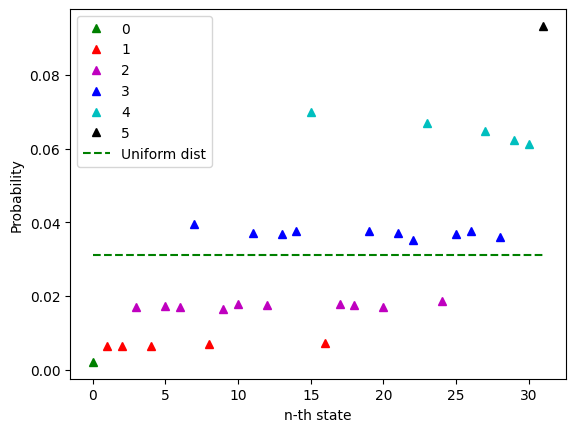

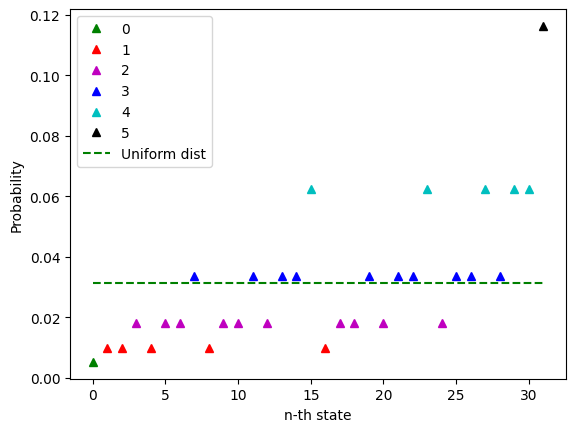

In [23]:
# Store trained weights
W = 1*rbm.W
v_bias = 1*rbm.v_bias
h_bias = 1*rbm.h_bias
print(W, v_bias, h_bias)

# Compute P(v)
_, pv = compute_pv(W, v_bias, h_bias, all_states)

print(((pv - pv_exact) ** 2).sum() * len(dataset))
print(pv - pv_exact)

# Plot
for j, states in enumerate(sorted_states):
    plt.plot(states, pv[states], f"{colors[j]}^", label=f"{j}")

plt.plot(np.arange(32), [1/32 for i in range(32)], "g--", label="Uniform dist")
plt.xlabel("n-th state")
plt.ylabel("Probability")
plt.legend()
plt.show()

# Plot exact distribution
for j, states in enumerate(sorted_states):
    plt.plot(states, pv_exact[states], f"{colors[j]}^", label=f"{j}")

plt.plot(np.arange(32), [1/32 for i in range(32)], "g--", label="Uniform dist")
plt.xlabel("n-th state")
plt.ylabel("Probability")
plt.legend()
plt.show()

### Now lets perform the same test for a bunch of different choice for W


Results for W = Identity
##################################

Partition function Z = 6114.03271484375
Epoch [5000/5000], Reconstructions errors: [tensor(227.0427, dtype=torch.float64), tensor(166.3456, dtype=torch.float64), tensor(918.4935, dtype=torch.float64)]

Input weights:
W = tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
Visible bias = tensor([0., 0., 0., 0., 0.])
Hidden bias = tensor([0., 0., 0., 0., 0.])

Learned weights:
W = Parameter containing:
tensor([[-0.0971, 12.1134, -0.1185, -0.2061, -0.1166],
        [-0.0779, -0.0219,  0.0411, 12.1977, -0.2404],
        [-0.0460, -0.1178, -0.2649,  0.0917, 12.2096],
        [-0.1269, -0.1563, 12.1830, -0.3407,  0.0784],
        [12.1139, -0.1088, -0.1145, -0.1481, -0.1229]])
Visible bias = Parameter containing:
tensor([-5.3860, -5.6019, -5.5713, -5.4398, -5.4063])
Hidden bias = Parameter containing:
tensor([-5.4769, -5.4475, -5.472

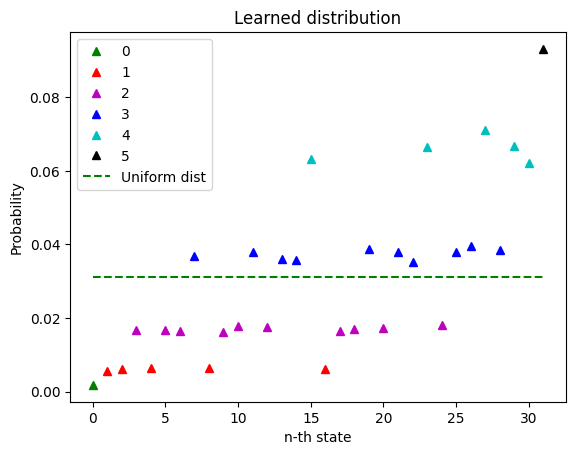

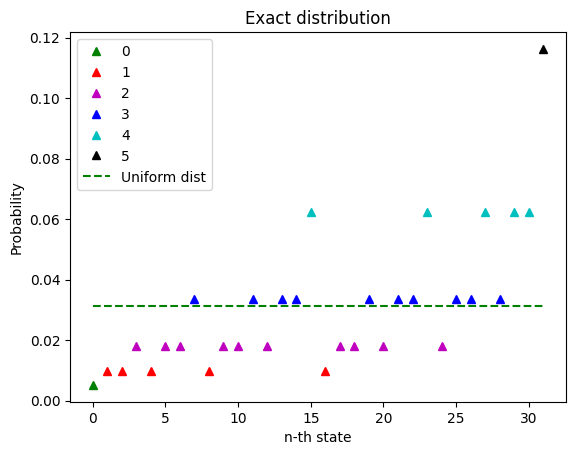


Results for W = 1's
##################################

Partition function Z = 77161996288.0
Epoch [5000/5000], Reconstructions errors: [tensor(199.3781, dtype=torch.float64), tensor(1134.0868, dtype=torch.float64), tensor(0.2398, dtype=torch.float64)]

Input weights:
W = tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
Visible bias = tensor([0., 0., 0., 0., 0.])
Hidden bias = tensor([0., 0., 0., 0., 0.])

Learned weights:
W = Parameter containing:
tensor([[0.7365, 0.7563, 0.7811, 0.7377, 0.7243],
        [0.7410, 0.7992, 0.7440, 0.7793, 0.7753],
        [0.7908, 0.7604, 0.7415, 0.7346, 0.7806],
        [0.6918, 0.7365, 0.7565, 0.7993, 0.7661],
        [0.7349, 0.8082, 0.7428, 0.7503, 0.7252]])
Visible bias = Parameter containing:
tensor([1.1547, 1.2506, 1.2053, 1.1850, 1.2213])
Hidden bias = Parameter containing:
tensor([-0.9789, -0.6566, -0.6658, -0.6749, -0.8068])
Partition functio

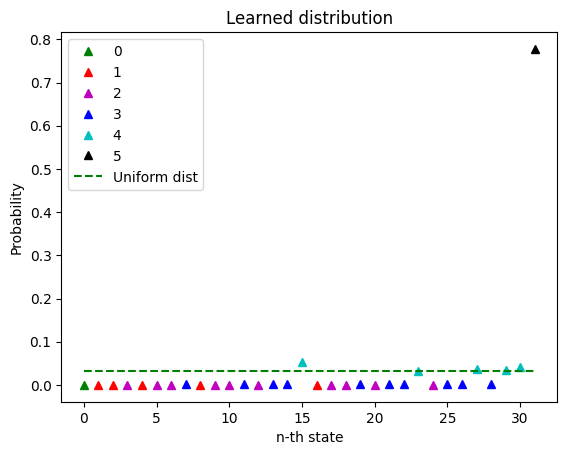

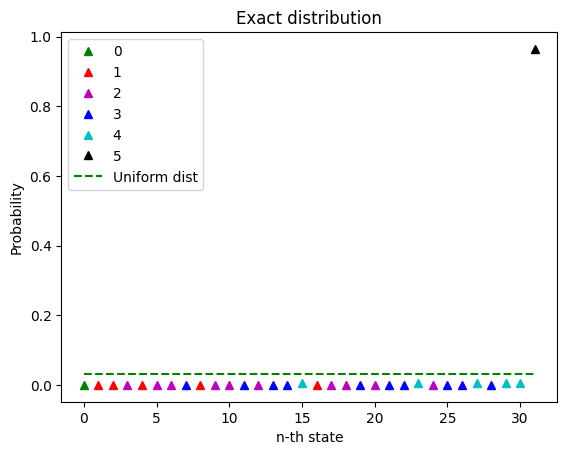


Results for W = 1's - identity
##################################

Partition function Z = 588912000.0
Epoch [5000/5000], Reconstructions errors: [tensor(508.7672, dtype=torch.float64), tensor(1827.4042, dtype=torch.float64), tensor(6649.8945, dtype=torch.float64)]

Input weights:
W = tensor([[0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 0.]])
Visible bias = tensor([0., 0., 0., 0., 0.])
Hidden bias = tensor([0., 0., 0., 0., 0.])

Learned weights:
W = Parameter containing:
tensor([[-3.9316,  9.5894,  2.2201,  0.1078, -0.6067],
        [-2.2144, -1.4907,  5.7432,  4.8908,  0.9079],
        [ 5.1765, -1.7646,  5.4667, -2.8965,  2.8264],
        [ 3.5858, -1.0233, -3.1532,  0.8748,  6.5033],
        [ 5.2031,  2.0387, -2.7478,  4.4595, -2.0299]])
Visible bias = Parameter containing:
tensor([ 2.2584,  0.5826, -0.0540,  1.1415,  0.4186])
Hidden bias = Parameter containing:
tensor([-5.0611, -3.8630, -4.

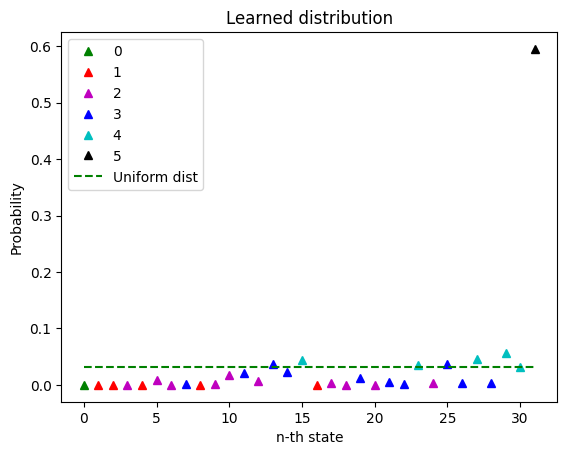

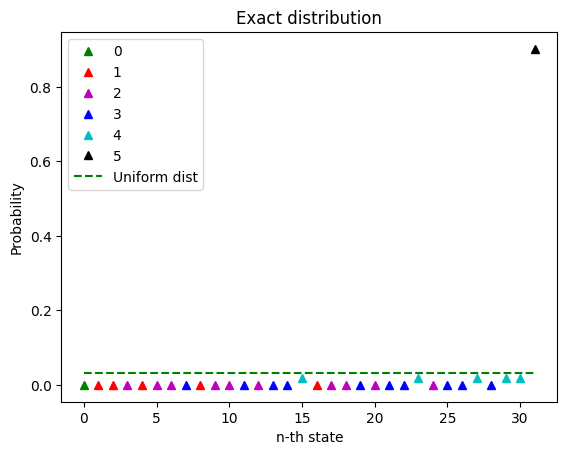


Results for W = Diagonal ones of size 3
##################################

Partition function Z = 1124639.0
Epoch [5000/5000], Reconstructions errors: [tensor(231.7623, dtype=torch.float64), tensor(189.4492, dtype=torch.float64), tensor(1851.4719, dtype=torch.float64)]

Input weights:
W = tensor([[1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.]])
Visible bias = tensor([0., 0., 0., 0., 0.])
Hidden bias = tensor([0., 0., 0., 0., 0.])

Learned weights:
W = Parameter containing:
tensor([[ 0.6144,  1.8181, -1.7319, 11.8648, -0.7076],
        [ 0.9613, 12.1717,  1.3480, -2.0681, -1.3398],
        [-2.9727, -2.2033, 11.6526,  1.2632,  1.3177],
        [11.7290, -1.5631,  1.9727, -1.2419, -0.9356],
        [ 0.3986,  0.4707, -2.2679,  0.3074, 11.7018]])
Visible bias = Parameter containing:
tensor([-5.1553, -4.2740, -1.9852, -3.1501, -4.0215])
Hidden bias = Parameter containing:
tensor([-3.5698, -3.194

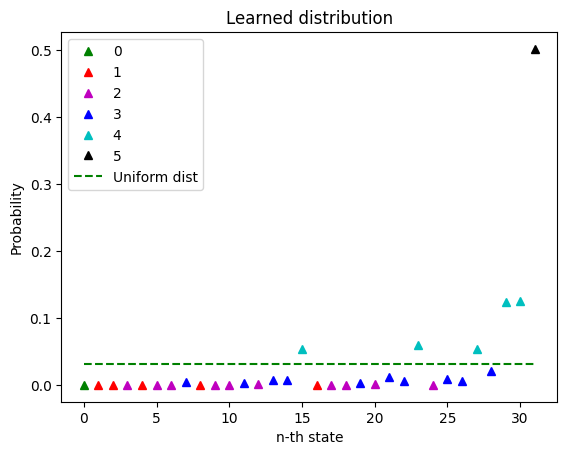

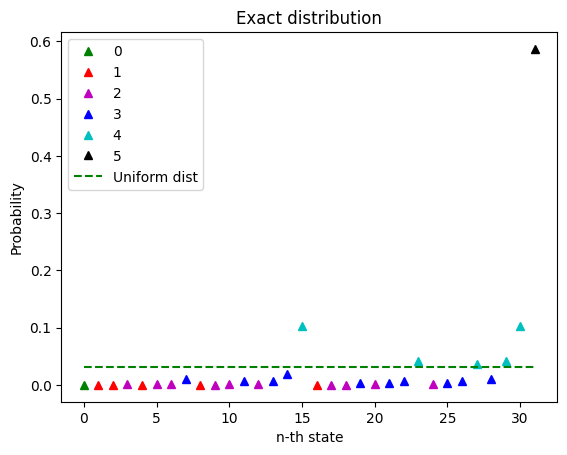


Results for W = I + 1's first row
##################################

Partition function Z = 82036.609375
Epoch [5000/5000], Reconstructions errors: [tensor(391.6285, dtype=torch.float64), tensor(509.7006, dtype=torch.float64), tensor(4865.0361, dtype=torch.float64)]

Input weights:
W = tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 0., 1., 0., 0.],
        [1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1.]])
Visible bias = tensor([0., 0., 0., 0., 0.])
Hidden bias = tensor([0., 0., 0., 0., 0.])

Learned weights:
W = Parameter containing:
tensor([[ 3.2544,  3.3105, -7.8564,  0.7274,  0.4156],
        [-0.3012, -0.4967,  0.8288, -0.0322, 11.9455],
        [-0.9478, 11.0040,  6.2732, -0.1828,  0.1207],
        [10.8985, -0.6796,  6.5743, -0.2300, -0.2319],
        [-0.3703, -0.3305,  1.1934, 11.9434, -0.3228]])
Visible bias = Parameter containing:
tensor([ 3.8384, -5.6989, -7.1720, -7.0547, -5.7597])
Hidden bias = Parameter containing:
tensor([-6.9784, -7.1298, 

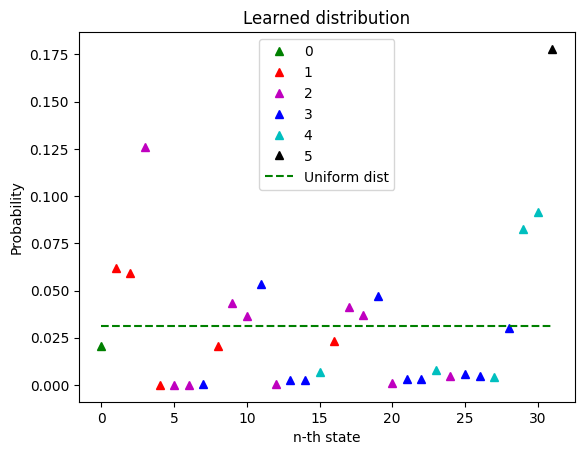

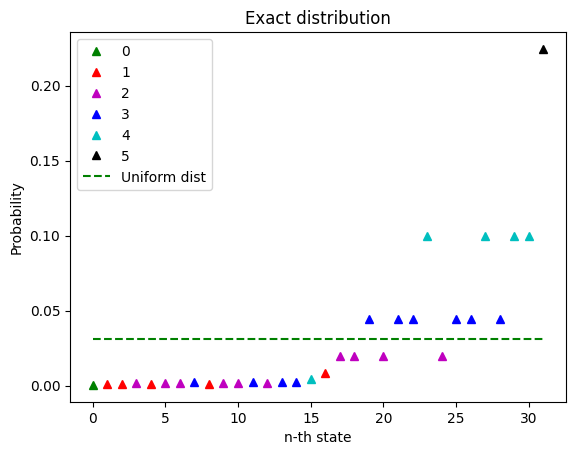


Results for W = I + 1's first column
##################################

Partition function Z = 82036.609375
Epoch [5000/5000], Reconstructions errors: [tensor(274.5571, dtype=torch.float64), tensor(208.1154, dtype=torch.float64), tensor(1063.6019, dtype=torch.float64)]

Input weights:
W = tensor([[1., 1., 1., 1., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
Visible bias = tensor([0., 0., 0., 0., 0.])
Hidden bias = tensor([0., 0., 0., 0., 0.])

Learned weights:
W = Parameter containing:
tensor([[ 1.2251e+01,  1.2414e+00, -1.7578e-01, -1.8693e-01, -4.5662e-01],
        [ 2.0475e-01,  1.1764e+00, -6.3746e-01,  3.1701e-03,  1.1752e+01],
        [-6.4368e-02,  1.0360e+00,  1.1694e+01, -3.9182e-01,  2.1660e-01],
        [-2.3969e-01,  1.1735e+00, -4.7881e-02,  1.1702e+01, -5.8606e-01],
        [ 1.6066e+00, -1.2074e+01,  1.1624e+00,  1.2094e+00,  1.1904e+00]])
Visible bias = Parameter containing:
tensor([-5.16

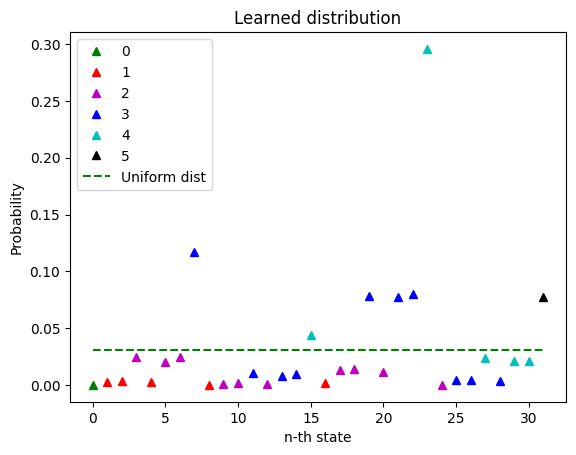

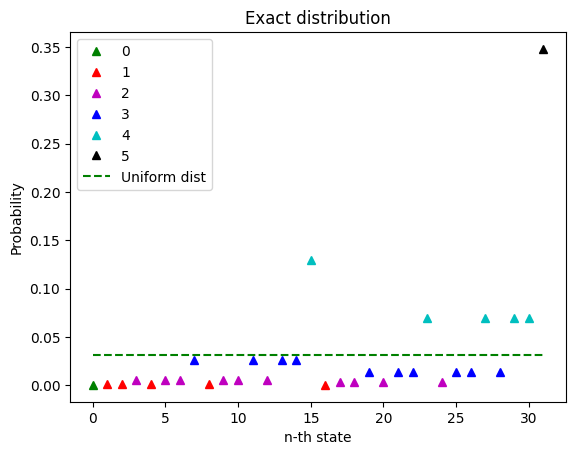

In [27]:
### Perform the same test on some other choices for W ###

# Set all biases to zero
v_bias = torch.zeros(5, dtype=torch.float) 
h_bias = torch.zeros(5, dtype=torch.float)

# Try different W
for i, W in enumerate(W_array):
    print(f"\nResults for W = {titles[i]}")
    print("##################################\n")
    run_test_two(W, v_bias, h_bias, verbose=False)